<a href="https://colab.research.google.com/github/Eloi-Le-Renard/Openclassrooms/blob/main/Project%205/POLIST_02_notebookessais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentez des clients d'un site e-commerce

Segmentation des clients d' "Olist" (site de vente en ligne) sur la période 2016-09-04 / 2018-10-17.

# Geo data

Localisation des achats des clients.

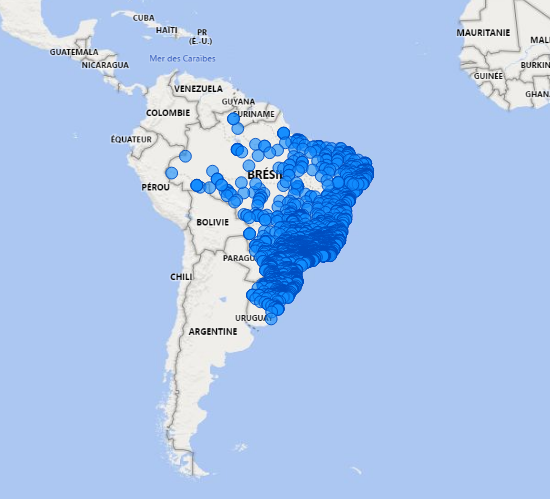


## Import

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import GridSearchCV

from datetime import datetime

In [ ]:
# to use google drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
def DBSCAN_GridSearch(data,eps=[2,2.5,3],min_samples=[1,2,3],verbose=True):
  """
  Performs a hyperparameter grid search for DBSCAN.
  data = data to fit the DBSCAN (should be scaled)
  """
  best_score = 0
  for e in eps:
    for m in min_samples:
      clustering = DBSCAN(eps=e, min_samples=m).fit(data)
      y = clustering.labels_
      score = silhouette_score(data, y)
      if verbose:
        print("param: eps="+str(e)+" min_samples="+str(m))
        print("score: "+str(score))
        print("Number of clusters: "+str(len(np.unique(y))))
      if score > best_score:
        best_score = score
        best_y = y
        best_param = [e,m]
  print("best param: eps="+str(best_param[0])+" min_samples="+str(best_param[1])+" ("+str(len(np.unique(best_y)))+" clusters)")
  return best_y,best_score

In [ ]:
review_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_order_reviews_dataset.csv')
customers_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_customers_dataset.csv')
items_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_order_items_dataset.csv')
payments_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_order_payments_dataset.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_orders_dataset.csv')
products_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_products_dataset.csv')
sellers_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/olist_sellers_dataset.csv')
categories_df = pd.read_csv('/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P5/data/product_category_name_translation.csv')

In [ ]:
def cleaning(data,columns=[],seuil_Sup=None,seuil_Inf=None):
    '''
    seuils inferieurs et superieurs sont strict > <
    '''
    res = data.copy()
    if len(columns) == 0: columns = data.columns
        
    # if threshold sup undefined
    if seuil_Sup == None:
        seuil_Sup = []
        print("default threshold: Q3 + (1.5*IQR) ")
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            # IQR is interquartile range
            IQR = Q3 - Q1
            limite = Q3 + (1.5*IQR)
            seuil_Sup.append(limite)
            print("for "+col+", threshold sup is: "+str(limite))
            
    # if threshold inf undefined
    if seuil_Inf == None:
        seuil_Inf = []
        print()
        print("default threshold: Q3 - (1.5*IQR) ")
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            # IQR is interquartile range
            IQR = Q3 - Q1
            limite = Q1 - (1.5*IQR)
            seuil_Inf.append(limite)
            print("for "+col+", threshold inf is: "+str(limite))
    k = 0
    print()
    for col in columns:
        #res.loc[res[col] >= seuil[k], col] = None
        res = res.drop(res[res[col] > seuil_Sup[k]].index)
        res = res.drop(res[res[col] < seuil_Inf[k]].index)
        print("ROWS after cleaning "+col+" : "+ str(len(res)))
        k += 1
        
    return res

In [ ]:
import seaborn as sns
def plot_NaN(data, limite = 0):
    """
    limite = display col with at least "limite" number of NaN
    """
    nb_nan = data.isna().sum()
    # pour voir que les colonnes avec NaN > limite
    nb_nan = nb_nan[nb_nan.values >= limite]

    d = {'Variables': nb_nan.index, 'Number of NaN': nb_nan.values}
    nb_nan_df = pd.DataFrame(data=d)
    plt.figure(figsize=(18, 8))

    nb_nan_df1 = nb_nan_df

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="Variables", y="Number of NaN", data=nb_nan_df1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_title('Nombre de \"NaN\" par variable', fontdict= { 'fontsize': 24, 'fontweight':'bold'})

In [ ]:
#import numpy as np
#import matplotlib.cm as cm
def plotCluster(name,clients,class_client,centroides,data_scale,S_score,vis_silhouette=True,inertiaS=[]):
    """
    clients = df with "freq","prices_tot","recency","review_score"
    centroides = list with coordinate of centroids [X,Y,Z]
    name = name of plot
    """
    nbCluster = len(centroides[0])
    fig = plt.figure(figsize=(35, 5))
    fig.suptitle(name)

    #===============
    #  Clients subplot
    #===============
    ax = fig.add_subplot(1, 8, 1, projection='3d')
    X,Y,Z = clients["freq"],clients["prices_tot"],clients["recency"]
    surf = ax.scatter(X,Y,Z, c=class_client, cmap='viridis',alpha=0.1,s = 1)
    ax.set_xlabel('F')
    ax.set_ylabel('M')
    ax.set_zlabel('R')
    ax.set_title("Clients")
    print("1/7..")

    #===============
    # Clusters subplot
    #===============
    ax = fig.add_subplot(1, 8, 2, projection='3d')
    X, Y, Z = centroides[-3],centroides[-2],centroides[-1]
    ax.scatter(X,Y,Z, c=range(nbCluster), cmap='viridis', marker='*', s=500)
    ax.set_xlabel('F')
    ax.set_ylabel('M')
    ax.set_zlabel('R')
    ax.set_zticklabels([])
    ax.set_title("Clusters")
    for c in range(nbCluster):
      ax.text(X[c],Y[c]+1,Z[c]+1,
              "F:"+str(round(X[c],1))+"\n"+
              "M:"+str(round(Y[c],1))+"\n"+
              "R:"+str(round(Z[c],1)), size=13, zorder=1, color='k') 
    print("2/7..")

    #===============
    # Pie charts
    #===============    
    (unique, counts) = np.unique(class_client, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    sizes = [ele[1] for ele in frequencies]
    cmap = cm.get_cmap('viridis')
    fractions = pd.array([i for i in range(0,nbCluster)])/(nbCluster-1)
    mycolors = [cmap(i) for i in fractions]
    ax = fig.add_subplot(1, 8, 3)
    ax.pie(x=sizes, autopct="%.1f%%", pctdistance=1.2, colors = mycolors)#, labels=range(len(sizes)))
    ax.set_title("class sizes")
    print("3/7..")
    
    #===============
    # silhouette plot
    #===============
    if vis_silhouette:
      fig = silhouettePlot(data_scale,class_client,S_score,fig)
      print("4/7..")

    #===============
    # cluster's inertia
    #===============
    if not vis_silhouette:
      ax = fig.add_subplot(1, 8, 4)
      ax.bar(range(len(inertiaS)), inertiaS, color=mycolors)
      ax.set_title("Clusters's inertia")
      print("4/7..")


    #===============
    # hist/cluster plot
    #===============
    fig = histClustPlot(centroides,nbCluster,mycolors,fig)

    plt.show()
    return fig

In [ ]:
def type_panier(data_merge,data_merge_full,classes_RFM):
  nb_clust = len(np.unique(classes_RFM))
  fig = plt.figure(figsize=(7*nb_clust, 7))
  fig.suptitle("type d'articles achetés en fonction des classes")
  subFig_num = 0
  for idx in np.unique(classes_RFM):
    subFig_num += 1
    temp = data_merge[classes_RFM == idx]
    temp = pd.merge(temp, data_merge_full, on='customer_unique_id')
    (values, counts) = np.unique(temp["product_category_name_english"], return_counts=True)
    # threshold = 5% of total clients in "idx_th" class
    threshold = sum(counts)/20
    product_category_len = counts[counts >= threshold]
    product_category_name = values[counts >= threshold]
    frequencies = np.asarray((product_category_name, product_category_len)).T
    sizes = [ele[1] for ele in frequencies]
    cmap = cm.get_cmap('viridis')
    fractions = pd.array([i for i in range(0,nb_clust)])/(nb_clust-1)
    ax = fig.add_subplot(1, nb_clust, subFig_num)
    sum_low_freq = sum(counts[counts < threshold])
    sizes = np.append(sizes,[sum_low_freq])
    product_category_name = np.append(product_category_name,["other (< 5%)"])
    ax.pie(x=sizes, autopct="%.1f%%", labels=product_category_name)
    ax.set_title("type of products bought (class "+str(subFig_num-1)+")")
  plt.show()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
def clusters_inertia(data,labels,centroids):
  c_index = 0
  labels_uniques = np.unique(labels)
  sums = []
  for c in centroids:
    sum = 0
    for d in data[labels == labels_uniques[c_index]].values:      
      sum += euclidean_distances([c],[d], squared=True)
    len_data_c_index = len(data[labels == c_index].values)
    if sum != 0:
      sums.append(sum[0][0]/len_data_c_index)
    else: print("Warning: one class's inertia = 0 !")
    c_index += 1
  return sums

In [ ]:
def histClustPlot(centroids,nbCluster,mycolors,fig=None):
  if fig == None: fig = plt.figure(figsize=(20, 5))
  label = ["Frequency","Monetary","Recency"]#,"review_score"]
  for i in range(3):
    d = {'Class': range(nbCluster), label[-i-1]: centroids[-i-1]}
    RFM_mean_centroids = pd.DataFrame(data=d)
    ax = fig.add_subplot(1, 8, i+5)
    ax.bar(RFM_mean_centroids["Class"], RFM_mean_centroids[label[-i-1]],color=mycolors)
    ax.set_title("Clusters's "+label[-i-1])
    ax.set_ylabel('')
    if label[-i-1] == "Recency": ax.invert_yaxis()
    print(str(i+5)+"/7..")

  return fig

In [ ]:
def silhouettePlot(data_scale,Y,S_score,fig=None):
    """
    data_scale = data scale
    Y = class index of data in "data_scale" (numpy array)
    """
    nbClust = len(np.unique(Y))

    #===============
    # silhouette plot
    #===============
    if fig == None: fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 8, 4)
    sample_silhouette_values = silhouette_samples(data_scale, Y)
    y_lower = 10
    for i in range(nbClust):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[Y == i]
      ith_cluster_silhouette_values.sort()
      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / nbClust)
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=S_score, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    return fig

In [ ]:
def elbowMethod(data,From=1,To=10):
  """
  display elbow method's plot
  """
  distortions = []
  for k in range(From,To):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
  plt.plot(range(From,To), distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

## Présentation générale

In [ ]:
customers_df.head(2)

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP

[2 rows x 5 columns]

In [ ]:
items_df.head(2)

order_id  order_item_id  ...  price freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.9         13.29
1  00018f77f2f0320c557190d7a144bdd3              1  ...  239.9         19.93

[2 rows x 7 columns]

In [ ]:
payments_df.head(2)

order_id  ...  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17  ...          99.33
1  a9810da82917af2d9aefd1278f1dcfa0  ...          24.39

[2 rows x 5 columns]

In [ ]:
payments_df[payments_df["order_id"] == "b81ef226f3fe1789b1e8b2acac839d17"]

order_id  ...  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17  ...          99.33

[1 rows x 5 columns]

In [ ]:
items_df[items_df["order_id"] == "b81ef226f3fe1789b1e8b2acac839d17"]

order_id  order_item_id  ... price freight_value
80985  b81ef226f3fe1789b1e8b2acac839d17              1  ...  79.8         19.53

[1 rows x 7 columns]

In [ ]:
payments_df.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

In [ ]:
orders_df.head(2)

order_id  ... order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  ...           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  ...           2018-08-13 00:00:00

[2 rows x 8 columns]

In [ ]:
orders_df.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [ ]:
products_df.head(2)

product_id  ... product_width_cm
0  1e9e8ef04dbcff4541ed26657ea517e5  ...             14.0
1  3aa071139cb16b67ca9e5dea641aaa2f  ...             20.0

[2 rows x 9 columns]

In [ ]:
sellers_df.head(2)

seller_id  ...  seller_state
0  3442f8959a84dea7ee197c632cb2df15  ...            SP
1  d1b65fc7debc3361ea86b5f14c68d2e2  ...            SP

[2 rows x 4 columns]

In [ ]:
categories_df.head(2)

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories

## Fusion des differents fichiers

On utilise le fichier de traduction pour decrire la **categorie des produits en anglais**

In [ ]:
data_merge = pd.merge(products_df, categories_df, on='product_category_name')
data_merge.head(3)

product_id  ... product_category_name_english
0  1e9e8ef04dbcff4541ed26657ea517e5  ...                     perfumery
1  6a2fb4dd53d2cdb88e0432f1284a004c  ...                     perfumery
2  0d009643171aee696f4733340bc2fdd0  ...                     perfumery

[3 rows x 10 columns]

In [ ]:
data_merge = pd.merge(items_df, data_merge, on='product_id')
data_merge.head(3)

order_id  ...  product_category_name_english
0  00010242fe8c5a6d1ba2dd792cb16214  ...                     cool_stuff
1  130898c0987d1801452a8ed92a670612  ...                     cool_stuff
2  532ed5e14e24ae1f0d735b91524b98b9  ...                     cool_stuff

[3 rows x 16 columns]

In [ ]:
data_merge = pd.merge(orders_df, data_merge, on='order_id')
data_merge.head(3)

order_id  ... product_category_name_english
0  e481f51cbdc54678b7cc49136f2d6af7  ...                    housewares
1  53cdb2fc8bc7dce0b6741e2150273451  ...                     perfumery
2  47770eb9100c2d0c44946d9cf07ec65d  ...                          auto

[3 rows x 23 columns]

In [ ]:
data_merge = pd.merge(customers_df, data_merge, on='customer_id')
data_merge.head(3)

customer_id  ... product_category_name_english
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...              office_furniture
1  18955e83d337fd6b2def6b18a428ac77  ...                    housewares
2  4e7b3e00288586ebd08712fdd0374a03  ...              office_furniture

[3 rows x 27 columns]

In [ ]:
data_merge = pd.merge(review_df, data_merge, on='order_id')
data_merge.head(3)

review_id  ... product_category_name_english
0  7bc2406110b926393aa56f80a40eba40  ...                sports_leisure
1  7bc2406110b926393aa56f80a40eba40  ...                sports_leisure
2  80e641a11e56f04c1ad469d5645fdfde  ...         computers_accessories

[3 rows x 33 columns]

In [ ]:
nbr_row = data_merge.shape[0]
nbr_col = data_merge.shape[1]
print("nombre d'individus : "+ str(nbr_row))
print("nombre de variables : "+ str(nbr_col))
data_numerical = data_merge.select_dtypes(include=np.number)
data_categorical = data_merge.select_dtypes(exclude=np.number)
print("Dont " + str(data_numerical.shape[1]) + " numeriques")
print("Dont " + str(data_categorical.shape[1]) + " categoriques")

nombre d'individus : 111686
nombre de variables : 33
Dont 12 numeriques
Dont 21 categoriques


In [ ]:
data_merge.nunique()

review_id                        97054
order_id                         97256
review_score                         5
review_comment_title              4549
review_comment_message           35910
review_creation_date               634
review_answer_timestamp          96898
customer_id                      97256
customer_unique_id               94088
customer_zip_code_prefix         14927
customer_city                     4095
customer_state                      27
order_status                         7
order_purchase_timestamp         96721
order_approved_at                88964
order_delivered_carrier_date     79802
order_delivered_customer_date    94337
order_estimated_delivery_date      450
order_item_id                       21
product_id                       32328
seller_id                         3033
shipping_limit_date              92053
price                             5899
freight_value                     6977
product_category_name               71
product_name_lenght      

In [ ]:
data_merge_full = data_merge.copy()

## Feature engineering 3 variables

On élimine les commandes annulées (~500 commandes)

In [ ]:
print("From "+ str(data_merge.shape[0]) + " rows")
data_merge = data_merge[data_merge["order_status"] != "canceled"]
print("To "+ str(data_merge.shape[0]) +" rows (after drop duplicate)")

From 111686 rows
To 111156 rows (after drop duplicate)


### Pre-selection des variables

On essaye l'approche RFM

In [ ]:
# Keep a copy of full data for later
data_merge_full = data_merge.copy()

In [ ]:
col_keep = ["customer_unique_id","order_purchase_timestamp","order_status","price"]
data_merge[col_keep]

customer_unique_id  ...   price
0       68a5590b9926689be4e10f4ae2db21a8  ...  185.00
1       68a5590b9926689be4e10f4ae2db21a8  ...  185.00
2       64190b91b656ab8f37eb89b93dc84584  ...   79.79
3       1d47144362c14e94ccdd213e8ec277d5  ...  149.00
4       c8cf6cb6b838dc7a33ed199b825e8616  ...  179.99
...                                  ...  ...     ...
111681  597cbb334f18a671472f7e16648228b4  ...  199.99
111682  c860357db400d72a2497064f8376fba9  ...  215.97
111683  96ac4cb74918d3ace141d3d3ddc1ff02  ...   50.95
111684  c3793040f54f0f511e5bcaa8937d0b0a  ...   10.00
111685  432d4f5ec4f462779a48a51c33950351  ...   32.90

[111156 rows x 4 columns]

In [ ]:
data_merge = data_merge[col_keep]

In [ ]:
# duplicateRowsDF is used to count the number of purchases
duplicateRowsDF = data_merge[data_merge.duplicated(['customer_unique_id'])]
display(duplicateRowsDF)

customer_unique_id  ...  price
1       68a5590b9926689be4e10f4ae2db21a8  ...  185.0
7       bda84be75dfc9588ae63cfe827080b9b  ...   99.9
8       bda84be75dfc9588ae63cfe827080b9b  ...   99.9
9       bda84be75dfc9588ae63cfe827080b9b  ...  119.0
16      92dcd4992a1c796d78efe76628436880  ...  121.9
...                                  ...  ...    ...
111657  c9ae1d598a33315fdace01e3bfefc5ea  ...  105.0
111658  c9ae1d598a33315fdace01e3bfefc5ea  ...  105.0
111659  c9ae1d598a33315fdace01e3bfefc5ea  ...  105.0
111660  c9ae1d598a33315fdace01e3bfefc5ea  ...  105.0
111675  2004ba7732339d9be65f2236d8887ae4  ...  115.0

[17485 rows x 4 columns]

In [ ]:
print(str(duplicateRowsDF["customer_unique_id"].nunique()) + " clients aux achats multiples")

11686 clients aux achats multiples


In [ ]:
# save the info "how many items each client buy"
ids_duplicat = duplicateRowsDF['customer_unique_id'].value_counts()

### Ajout des variables R+F+M

#### F freq

On ajoute la variable **"freq" = le nombre d'achat effectué par le client**

In [ ]:
data_merge["freq"] = 1

In [ ]:
# On ajuste les valeurs de la colonne "nb_achat" pour les clients qui commandes + d'1 article.
for id_achat_multiple in ids_duplicat.index:
    data_merge["freq"][data_merge["customer_unique_id"] == id_achat_multiple] = ids_duplicat[id_achat_multiple]+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Nos clients avec plus d'un achat effectué

In [ ]:
data_merge[data_merge["freq"] > 1]

customer_unique_id order_purchase_timestamp  ...  price  freq
0       68a5590b9926689be4e10f4ae2db21a8      2018-01-11 15:30:49  ...  185.0     2
1       68a5590b9926689be4e10f4ae2db21a8      2018-01-11 15:30:49  ...  185.0     2
6       bda84be75dfc9588ae63cfe827080b9b      2018-04-06 22:18:54  ...   99.9     4
7       bda84be75dfc9588ae63cfe827080b9b      2018-04-06 22:18:54  ...   99.9     4
8       bda84be75dfc9588ae63cfe827080b9b      2018-04-06 22:18:54  ...   99.9     4
...                                  ...                      ...  ...    ...   ...
111657  c9ae1d598a33315fdace01e3bfefc5ea      2018-05-21 14:14:35  ...  105.0     6
111658  c9ae1d598a33315fdace01e3bfefc5ea      2018-05-21 14:14:35  ...  105.0     6
111659  c9ae1d598a33315fdace01e3bfefc5ea      2018-05-21 14:14:35  ...  105.0     6
111660  c9ae1d598a33315fdace01e3bfefc5ea      2018-05-21 14:14:35  ...  105.0     6
111675  2004ba7732339d9be65f2236d8887ae4      2018-05-10 11:23:03  ...  115.0     3

[29171 rows x 5 columns]

#### M prices_tot

Remarque: il semblerai que la plus part des achats multiples concerne le meme produit.

In [ ]:
price_mean = data_merge.groupby('customer_unique_id').price.mean()

In [ ]:
price_mean_df = pd.DataFrame(price_mean)

In [ ]:
price_mean_df.rename(columns={"price": "prices_mean"}, inplace=True)

In [ ]:
price_mean_df

prices_mean
customer_unique_id                           
0000366f3b9a7992bf8c76cfdf3221e2       129.90
0000b849f77a49e4a4ce2b2a4ca5be3f        18.90
0000f46a3911fa3c0805444483337064        69.00
0000f6ccb0745a6a4b88665a16c9f078        25.99
0004aac84e0df4da2b147fca70cf8255       180.00
...                                       ...
fffcf5a5ff07b0908bd4e2dbc735a684       785.00
fffea47cd6d3cc0a88bd621562a9d061        64.89
ffff371b4d645b6ecea244b27531430a        89.90
ffff5962728ec6157033ef9805bacc48       115.00
ffffd2657e2aad2907e67c3e9daecbeb        56.99

[93671 rows x 1 columns]

In [ ]:
data_merge = pd.merge(data_merge, price_mean_df, on='customer_unique_id')

In [ ]:
# verif resultat
#data_merge[data_merge["customer_unique_id"] == "0f5ac8d5c31de21d2f25e24be15bbffb"]

In [ ]:
data_merge["prices_tot"] = data_merge["prices_mean"]*data_merge["freq"]

In [ ]:
data_merge.head(5)

customer_unique_id  ... prices_tot
0  68a5590b9926689be4e10f4ae2db21a8  ...     370.00
1  68a5590b9926689be4e10f4ae2db21a8  ...     370.00
2  64190b91b656ab8f37eb89b93dc84584  ...      79.79
3  1d47144362c14e94ccdd213e8ec277d5  ...     149.00
4  c8cf6cb6b838dc7a33ed199b825e8616  ...     179.99

[5 rows x 7 columns]

#### R recency

On convertit les dates: String => objet datetime

In [ ]:
data_merge["date"] = data_merge["order_purchase_timestamp"].apply(lambda x: datetime.fromisoformat(x))

Le dernier achat de nos clients (pour evaluer la récence des achats)

In [ ]:
date_reference = data_merge["date"].max()
date_reference

Timestamp('2018-09-03 09:06:57')

In [ ]:
# get max of each "group"=client
last_purchase = data_merge.groupby(by='customer_unique_id', as_index=False)['date'].max()

La date de dernier achat pour chaque client

In [ ]:
last_purchase

customer_unique_id                date
0      0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27
1      0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27
2      0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03
3      0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41
4      0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42
...                                 ...                 ...
93666  fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:00:36
93667  fffea47cd6d3cc0a88bd621562a9d061 2017-12-10 20:07:56
93668  ffff371b4d645b6ecea244b27531430a 2017-02-07 15:49:16
93669  ffff5962728ec6157033ef9805bacc48 2018-05-02 15:17:41
93670  ffffd2657e2aad2907e67c3e9daecbeb 2017-05-02 20:18:45

[93671 rows x 2 columns]

In [ ]:
last_purchase.columns = ['customer_unique_id', 'date_last_purchase']

In [ ]:
data_merge = pd.merge(data_merge, last_purchase, on='customer_unique_id')

In [ ]:
data_merge['recency'] = data_merge['date_last_purchase'].apply(lambda x: -(date_reference - x).days)

In [ ]:
data_merge.head(5)

customer_unique_id  ... recency
0  68a5590b9926689be4e10f4ae2db21a8  ...    -234
1  68a5590b9926689be4e10f4ae2db21a8  ...    -234
2  64190b91b656ab8f37eb89b93dc84584  ...    -186
3  1d47144362c14e94ccdd213e8ec277d5  ...    -211
4  c8cf6cb6b838dc7a33ed199b825e8616  ...    -511

[5 rows x 10 columns]

### Drop colonnes

On garde les colonnes qui sont utiles pour une analyse RFM

In [ ]:
col_keep = ["customer_unique_id","freq","prices_tot","recency"]
data_merge = data_merge[col_keep]

In [ ]:
data_merge.head(5)

customer_unique_id  freq  prices_tot  recency
0  68a5590b9926689be4e10f4ae2db21a8     2      370.00     -234
1  68a5590b9926689be4e10f4ae2db21a8     2      370.00     -234
2  64190b91b656ab8f37eb89b93dc84584     1       79.79     -186
3  1d47144362c14e94ccdd213e8ec277d5     1      149.00     -211
4  c8cf6cb6b838dc7a33ed199b825e8616     1      179.99     -511

### Drop doublons

In [ ]:
print("From "+ str(data_merge.shape[0]) + " rows")
data_merge.drop_duplicates(subset ="customer_unique_id", inplace = True)
print("To "+ str(data_merge.shape[0]) +" rows (after drop duplicate)")

From 111156 rows
To 93671 rows (after drop duplicate)


### Nettoyage

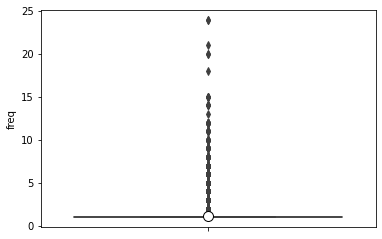

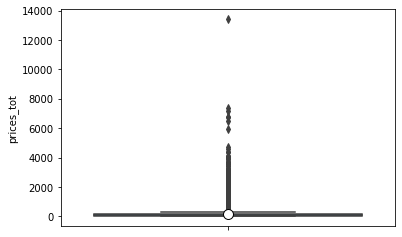

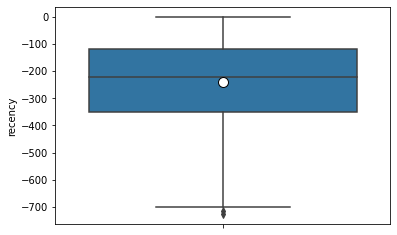

In [ ]:
import seaborn as sns

cols = ["freq","prices_tot","recency"]
for col in cols:
    ax = sns.boxplot(y=col, data=data_merge, showmeans=True,
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
    #ax.set_yscale('log')
    plt.show()

**Nettoyage Valeurs aberrantes**

Aucune valeur aberrante detectée

Le client ayant depensé le plus a commander 8*1680 euros avec comme commentaire: "Veuillez vérifier la livraison de la commande,..."

In [ ]:
data_merge[data_merge["prices_tot"] > 10000]

customer_unique_id  freq  prices_tot  recency
35561  0a0a92112bd4c708ca5fde585afaa872     8     13440.0     -338

In [ ]:
data_merge_full[data_merge_full["customer_unique_id"] == "0a0a92112bd4c708ca5fde585afaa872"]

review_id  ... product_category_name_english
33885  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33886  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33887  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33888  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33889  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33890  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33891  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony
33892  211fa81a22870cc634265ea85b751e40  ...               fixed_telephony

[8 rows x 33 columns]

**Nettoyage Valeurs atypiques**

Les valeurs atypiques sont justifiées

**Imputation Valeurs manquante**

Aucune valeur manquante

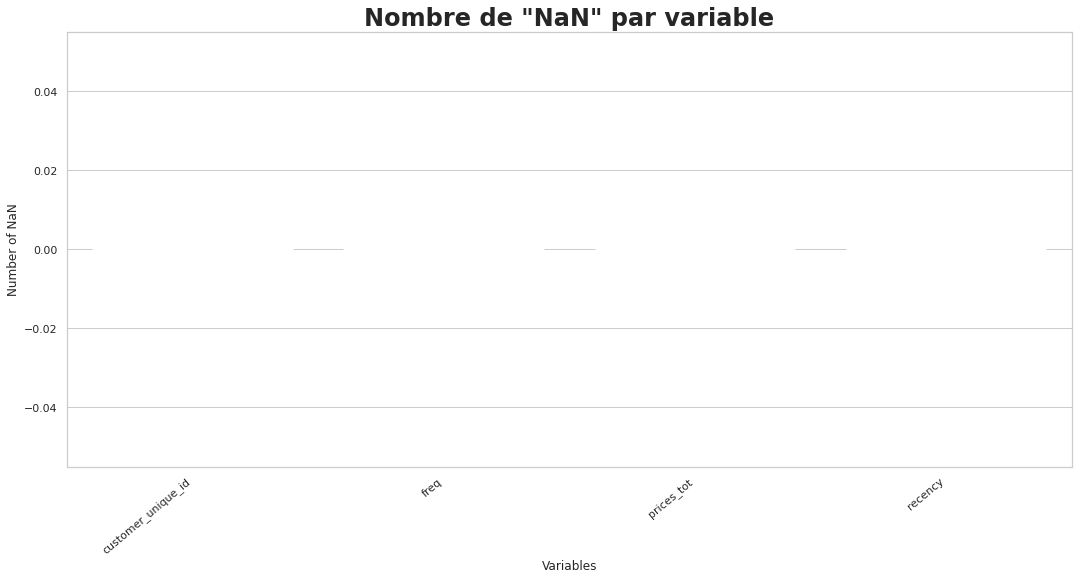

In [ ]:
plot_NaN(data_merge, limite = 0)

In [ ]:
rfm_df = data_merge[["freq","prices_tot","recency"]].copy()

## Segmentation 3 variables

### Segmentation quartiles

On segmente les clients avec la **méthode RFM**. On utilise les quartiles de nos variables pour separer les clients.

In [ ]:
quantiles = rfm_df.quantile(q=[0.2,0.4,0.6,0.8])
quantiles

freq  prices_tot  recency
0.2   1.0       39.90   -387.0
0.4   1.0       69.90   -272.0
0.6   1.0      109.90   -180.0
0.8   1.0      179.99    -96.0

In [ ]:
# split in 4 equal-sized buckets based on quartiles
data_merge['recency_score'] = pd.qcut(data_merge['recency'], 4, labels=False)

# split in 4 equal-sized buckets based on quartiles
data_merge['monetary_score'] = pd.qcut(data_merge['prices_tot'], 4, labels=False)

# create a list of our conditions
conditionsF = [
    (data_merge['freq'] <= quantiles.iloc[0,0]),
    (data_merge['freq'] > quantiles.iloc[0,0]) & (data_merge['freq'] <= quantiles.iloc[1,0]),
    (data_merge['freq'] > quantiles.iloc[1,0]) & (data_merge['freq'] <= quantiles.iloc[2,0]),
    (data_merge['freq'] > quantiles.iloc[2,0])
    ]
# create a list of the values we want to assign for each condition
values = [0, 1, 2, 3]
data_merge['freq_score'] = np.select(conditionsF, values)

# display updated DataFrame
data_merge.head()

customer_unique_id  freq  ...  monetary_score  freq_score
0  68a5590b9926689be4e10f4ae2db21a8     2  ...               3           3
2  64190b91b656ab8f37eb89b93dc84584     1  ...               1           0
3  1d47144362c14e94ccdd213e8ec277d5     1  ...               2           0
4  c8cf6cb6b838dc7a33ed199b825e8616     1  ...               3           0
5  d16000272660a1fef81482ad75ba572a     1  ...               3           0

[5 rows x 7 columns]

In [ ]:
score_clients = data_merge[["customer_unique_id","recency_score","freq_score","monetary_score"]].copy()
score_clients.head(5)

customer_unique_id  recency_score  freq_score  monetary_score
0  68a5590b9926689be4e10f4ae2db21a8              1           3               3
2  64190b91b656ab8f37eb89b93dc84584              2           0               1
3  1d47144362c14e94ccdd213e8ec277d5              2           0               2
4  c8cf6cb6b838dc7a33ed199b825e8616              0           0               3
5  d16000272660a1fef81482ad75ba572a              2           0               3

In [ ]:
score_clients["score"] = score_clients["recency_score"]+score_clients["freq_score"]+score_clients["monetary_score"]

In [ ]:
score_clients["score"].unique()

array([7, 3, 4, 5, 8, 0, 1, 6, 2, 9])

On segmente les clients en 4 classes (de même grandeur) par ordre croissant d'importance: **"bronze","silver","gold","premium"**

In [ ]:
score_clients['classe'] = pd.qcut(score_clients['score'], 4, labels=["bronze", "silver", "gold", "premium"])

In [ ]:
score_clients.head(5)

customer_unique_id  recency_score  ...  score   classe
0  68a5590b9926689be4e10f4ae2db21a8              1  ...      7  premium
2  64190b91b656ab8f37eb89b93dc84584              2  ...      3   silver
3  1d47144362c14e94ccdd213e8ec277d5              2  ...      4     gold
4  c8cf6cb6b838dc7a33ed199b825e8616              0  ...      3   silver
5  d16000272660a1fef81482ad75ba572a              2  ...      5     gold

[5 rows x 6 columns]

In [ ]:
le = LabelEncoder()
le.fit(score_clients["classe"])
classes_RFM = le.transform(score_clients["classe"])
classes_RFM

array([2, 3, 1, ..., 1, 0, 0])

In [ ]:
centroide0 = rfm_df[classes_RFM == 0].mean()
centroide1 = rfm_df[classes_RFM == 1].mean()
centroide2 = rfm_df[classes_RFM == 2].mean()
centroide3 = rfm_df[classes_RFM == 3].mean()
centroides2 = [centroide0.values,centroide1.values,centroide2.values,centroide3.values]

centroidesX = [centroide0[0],centroide1[0],centroide2[0],centroide3[0]]
centroidesY = [centroide0[1],centroide1[1],centroide2[1],centroide3[1]]
centroidesZ = [centroide0[2],centroide1[2],centroide2[2],centroide3[2]]
centroides = [centroidesX,centroidesY,centroidesZ]

In [ ]:
data_rfm = data_merge[["freq","prices_tot","recency"]].copy()

On utilise les données mis à l'echelle pour le calcul de silhouette

In [ ]:
sc = StandardScaler()

data_RFM_scale = sc.fit_transform(rfm_df)
data_RFM_scale = pd.DataFrame(data_RFM_scale, columns=rfm_df.columns)
data_RFM_scale.head(5)

freq  prices_tot   recency
0  1.25209    1.046379  0.050807
1 -0.28736   -0.289987  0.364486
2 -0.28736    0.028713  0.201111
3 -0.28736    0.171416 -1.759385
4 -0.28736    4.863777  0.246856

In [ ]:
S_score = silhouette_score(data_RFM_scale, classes_RFM)
S_score

0.0881553614556207

In [ ]:
DB_score = davies_bouldin_score(data_RFM_scale, classes_RFM)
DB_score

2.8560521185946324

In [ ]:
score_RFM_quartile = [S_score,DB_score]

In [ ]:
Clusters_inertia = clusters_inertia(data_RFM_scale,classes_RFM,centroides2)

#### Description des classes

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


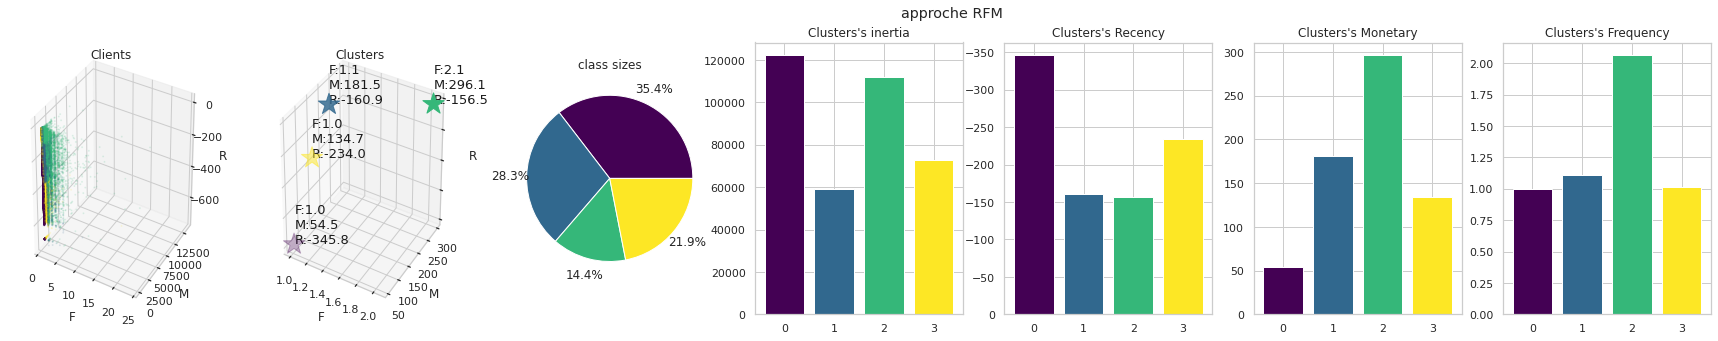

In [ ]:
plt_RFM_quartile = plotCluster("approche RFM",data_rfm,classes_RFM,centroides,data_RFM_scale,S_score,vis_silhouette=False,inertiaS=Clusters_inertia)

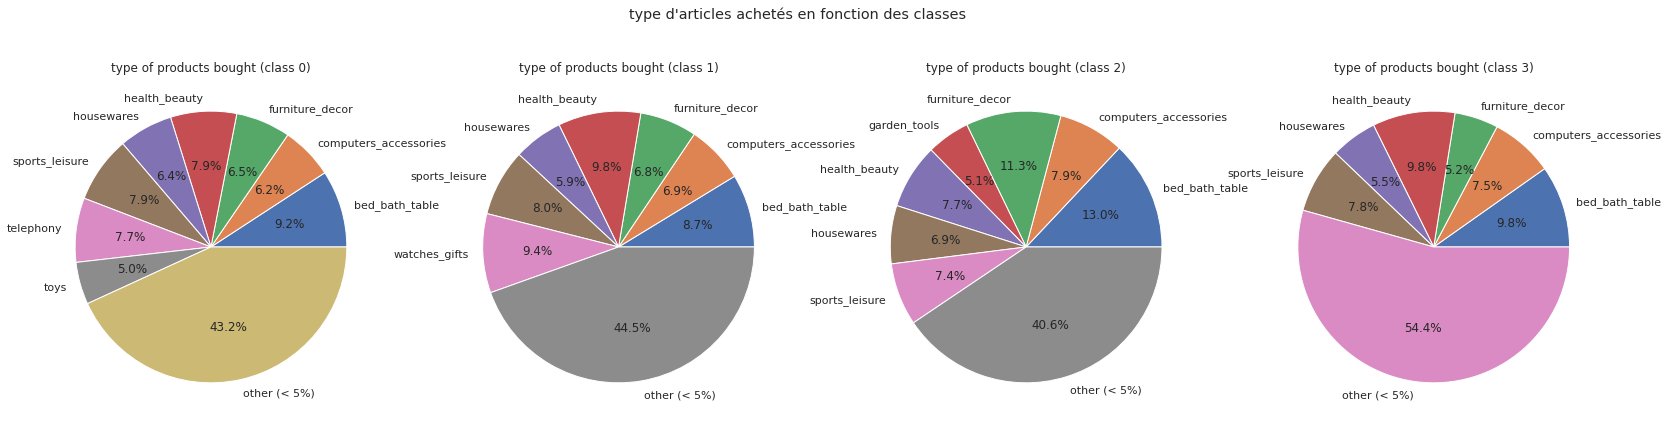

In [ ]:
type_panier(data_merge,data_merge_full,classes_RFM)

**Remarque:** Avec cette approche, on constate que les classes se distingues clairement par importance des clients.

### Segmentation Kmeans

On utilise l'elbow methode pour visualiser un compromis pour le nombre de classes 

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

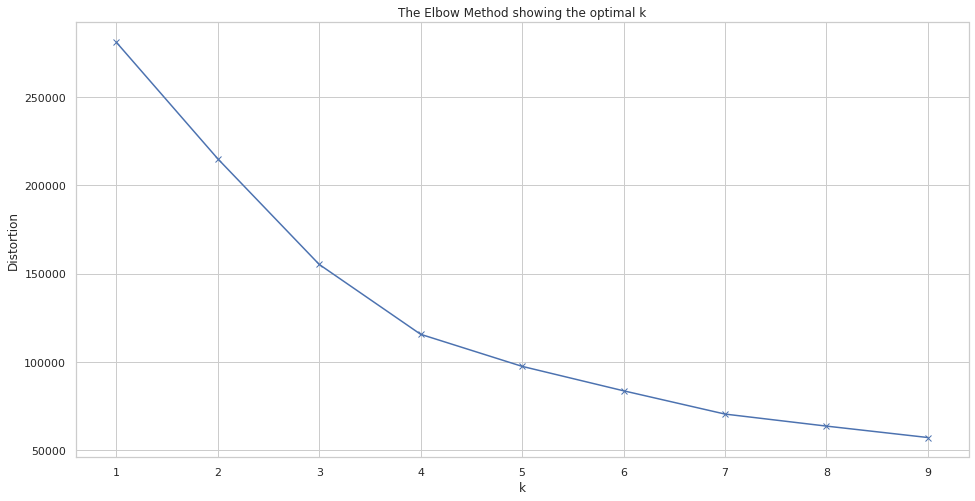

In [ ]:
elbowMethod(data_RFM_scale)

#### Description des classes

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


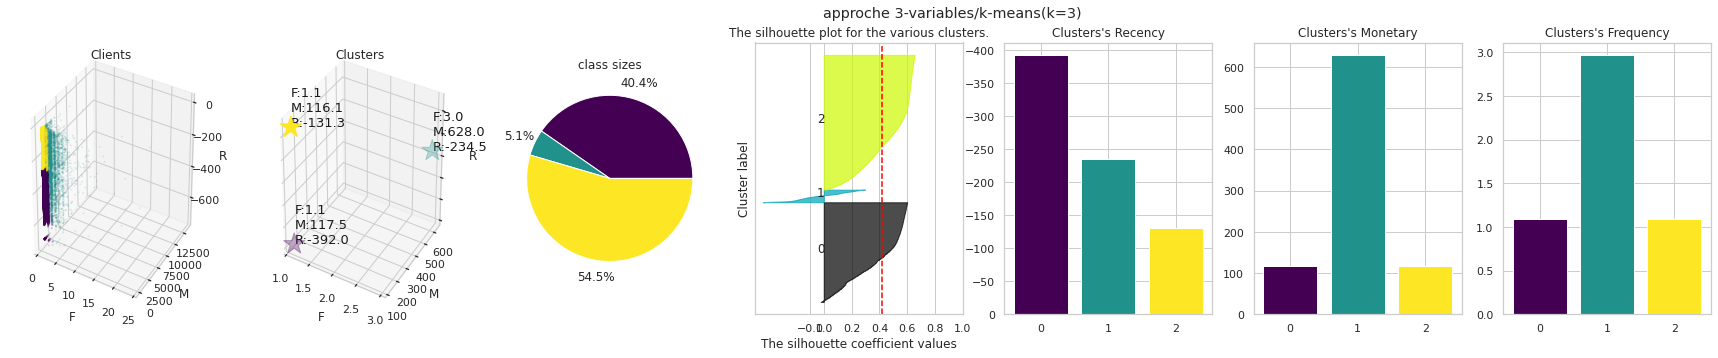

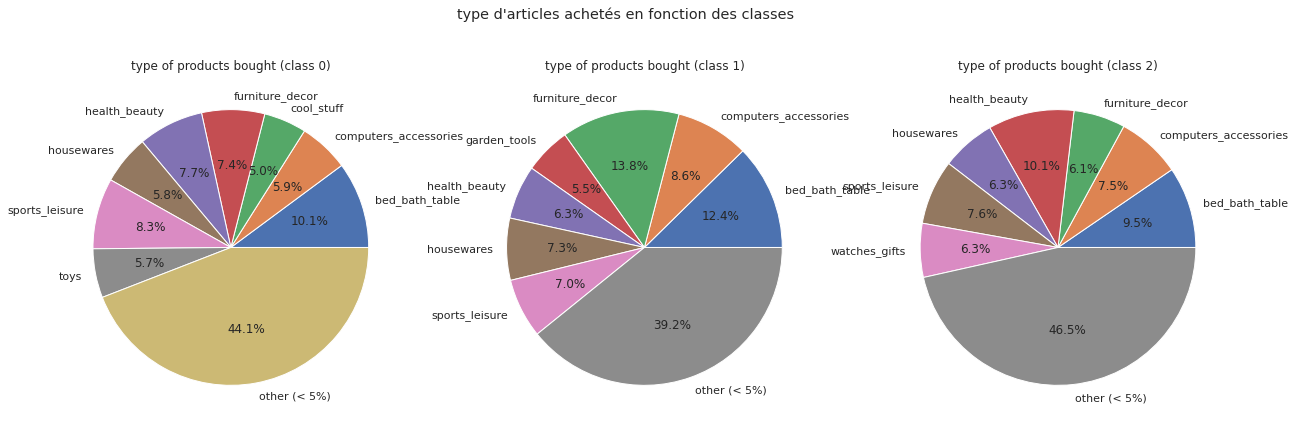

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


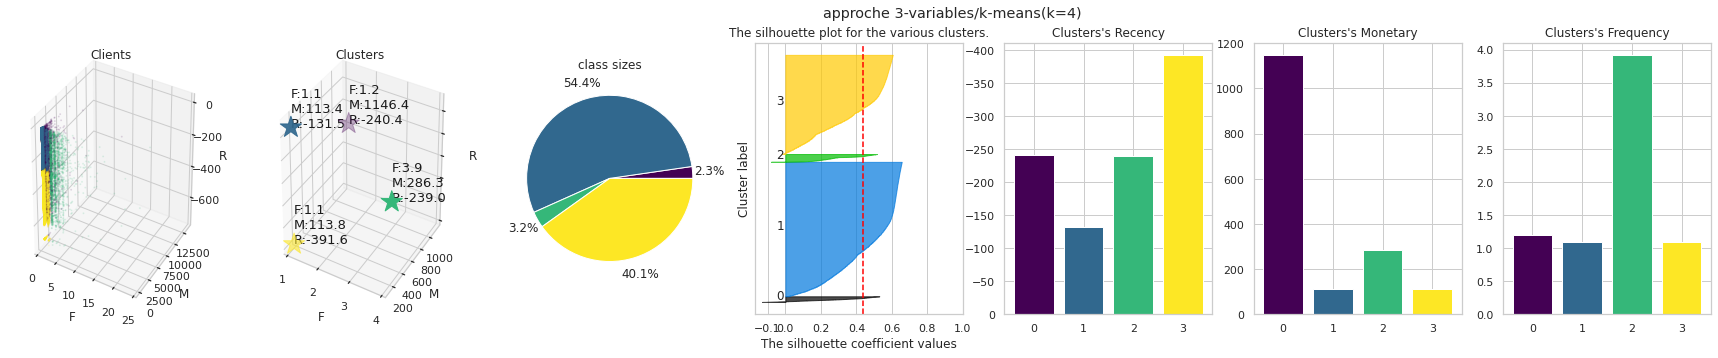

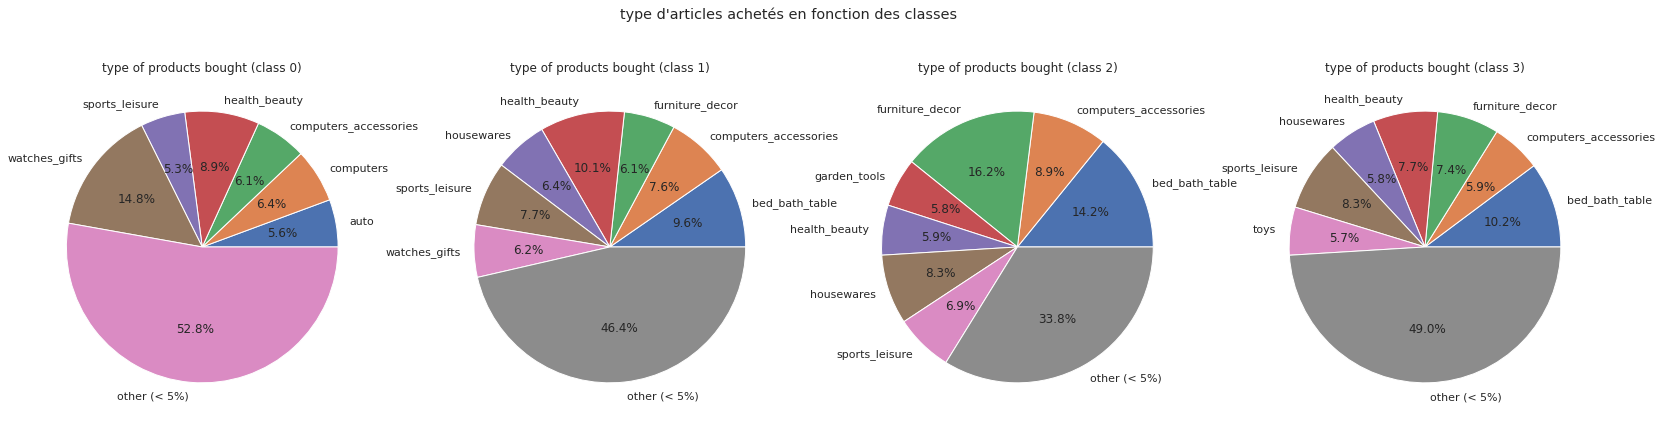

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


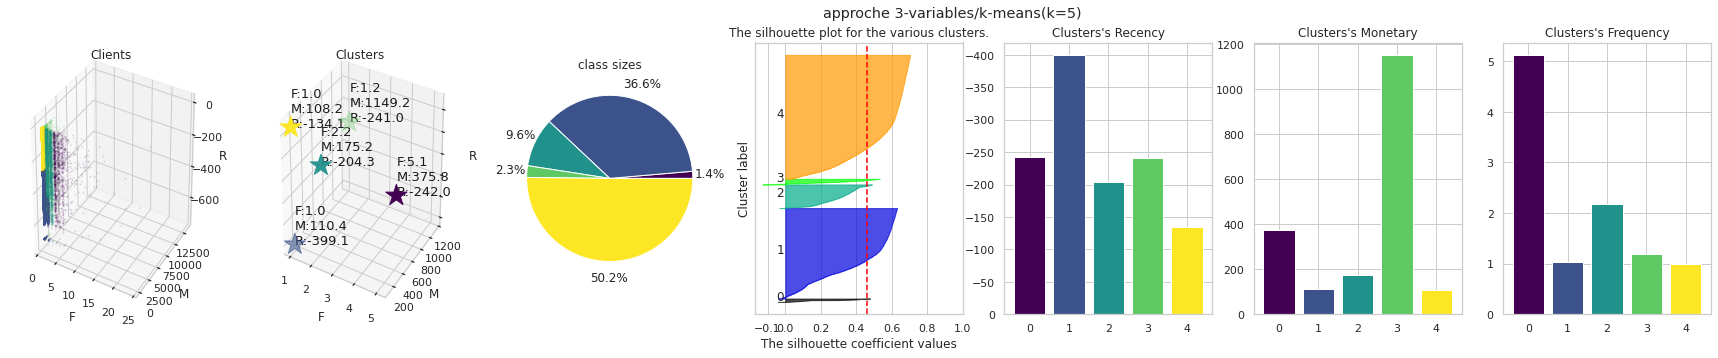

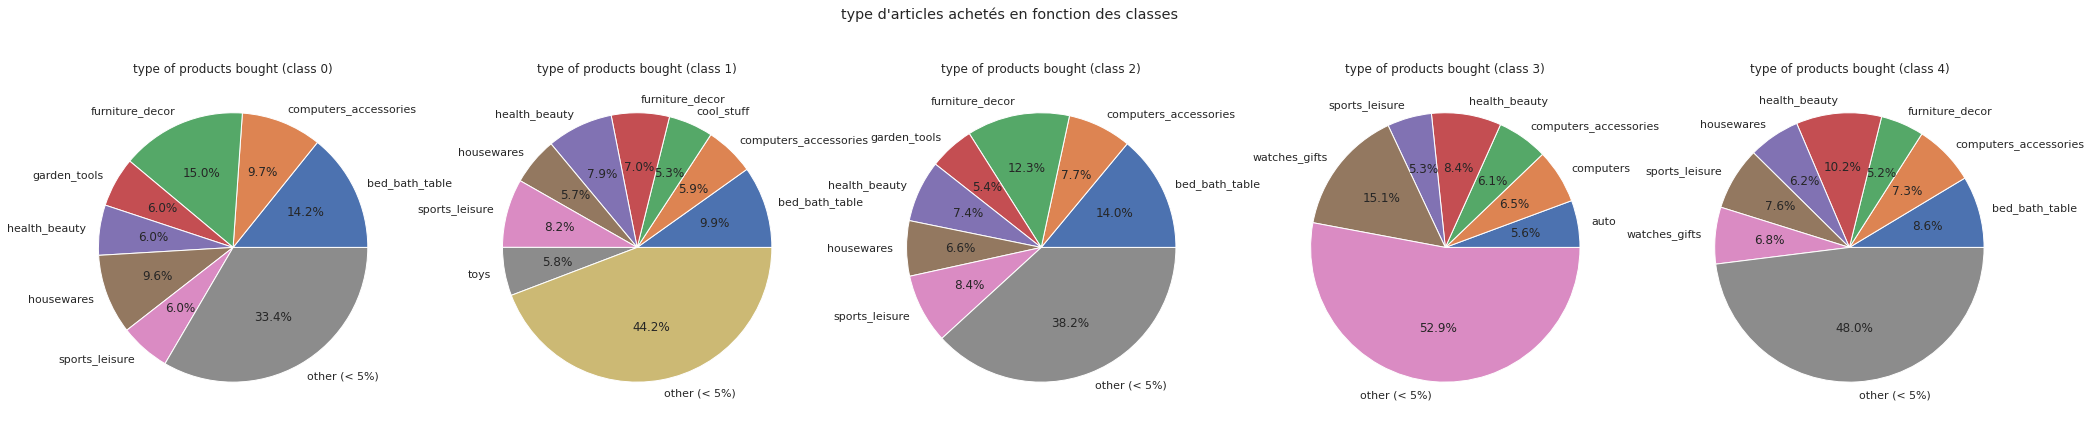

k=3       k=4       k=5
Silhouette  0.417717  0.436765  0.462664
Davis B.    1.083793  0.834533  0.802044

In [ ]:
plt_RFM_Kmeans = []
S_score = []
DB_score = []
y_kmeans_list = []

for nbCluster in range(3,6):
  kmeanModel = KMeans(n_clusters=nbCluster)
  kmeanModel.fit(data_RFM_scale)
  y_kmeans = kmeanModel.predict(data_RFM_scale)
  y_kmeans_list.append(y_kmeans)
  centroides = kmeanModel.cluster_centers_
  centroides_unscaled = sc.inverse_transform(centroides).T
  S_score_k = silhouette_score(data_RFM_scale, y_kmeans)
  S_score.append(S_score_k)
  DB_score.append(davies_bouldin_score(data_RFM_scale, y_kmeans))
  plt_RFM_Kmeans.append(plotCluster("approche 3-variables/k-means(k="+str(nbCluster)+")",
                                    data_rfm,y_kmeans,centroides_unscaled,data_RFM_scale,S_score_k))
  type_panier(data_merge,data_merge_full,y_kmeans)
  
score_RFM_Kmeans = [S_score,DB_score]
pd.DataFrame(score_RFM_Kmeans, columns=["k=3","k=4","k=5"],index=["Silhouette","Davis B."])

**Remarque:** Avec l'approche de segmentation par K-means en faisant varier "k", on constate que les clients se regroupe pour la majorité en **2 classes qui se distingue par la récence** du dernier achat des clients.


### Segmentation DBSCAN

Choisir la taille des données à conserver pour le DBSCAN (complexité élevé)

In [ ]:
# choose len of data for dbscan (30 000 on google colab is limit)
lenData = 30000
X = data_RFM_scale[:lenData]

In [ ]:
y_dbscan,S_score = DBSCAN_GridSearch(X, eps=[1,1.5])

param: eps=1 min_samples=1
score: 0.35649863555663924
Number of clusters: 73
param: eps=1 min_samples=2
score: 0.35778996182811756
Number of clusters: 26
param: eps=1 min_samples=3
score: 0.35726348698206034
Number of clusters: 17
param: eps=1.5 min_samples=1
score: 0.35839321127496265
Number of clusters: 46
param: eps=1.5 min_samples=2
score: 0.3587311519729505
Number of clusters: 22
param: eps=1.5 min_samples=3
score: 0.3591632034795146
Number of clusters: 15
best param: eps=1.5 min_samples=3 (15 clusters)


In [ ]:
DB_score = davies_bouldin_score(X, y_dbscan)
DB_score

1.6923511856048523

In [ ]:
score_RFM_DBSCAN = [S_score,DB_score]

In [ ]:
centroids = []
for c in np.unique(y_dbscan):
  # label "-1" = noise
  if c != -1:
    centroid = X[y_dbscan == c].mean()
    centroids.append(centroid)
centroides_unscaled = sc.inverse_transform(centroids).T

In [ ]:
Clusters_inertia = clusters_inertia(X,y_dbscan,[c.values for c in centroids])

On élimine les outliers pour qu'ils n'apparaissent pas comme une classe dans les resultats


In [ ]:
data_lenData = data_rfm[:lenData]
outliers2 = data_lenData[y_dbscan == -1]

data_lenData.reset_index(inplace=True, drop=True)
outliers = data_lenData[y_dbscan == -1]

In [ ]:
X_without_outliers = X.drop(outliers.index, inplace=False)
y_dbscan_without_outliers = y_dbscan[y_dbscan != -1]
data_rfm_without_outliers = data_rfm.drop(outliers2.index, inplace=False)

In [ ]:
X_without_outliers_unscaled = data_merge.iloc[X_without_outliers.index]

#### Description des classes

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


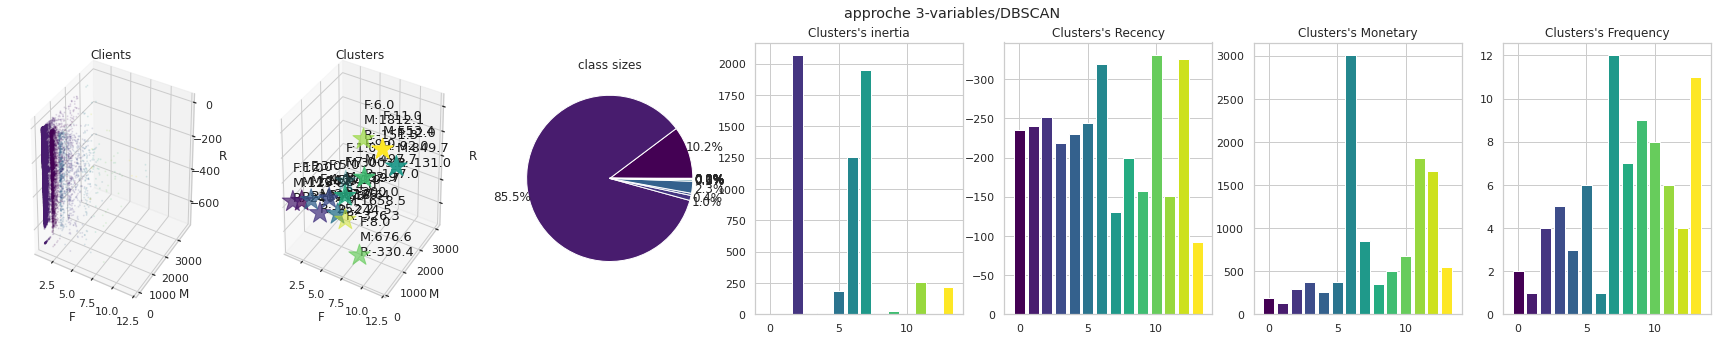

DBSCAN
Silhouette  0.359163
Davis B.    1.692351

In [ ]:
plt_RFM_DBSCAN = plotCluster("approche 3-variables/DBSCAN",X_without_outliers_unscaled,
                             y_dbscan_without_outliers,
                             centroides_unscaled,
                             X_without_outliers,
                             S_score,vis_silhouette=False,inertiaS=Clusters_inertia)
pd.DataFrame(score_RFM_DBSCAN, columns=["DBSCAN"],index=["Silhouette","Davis B."])

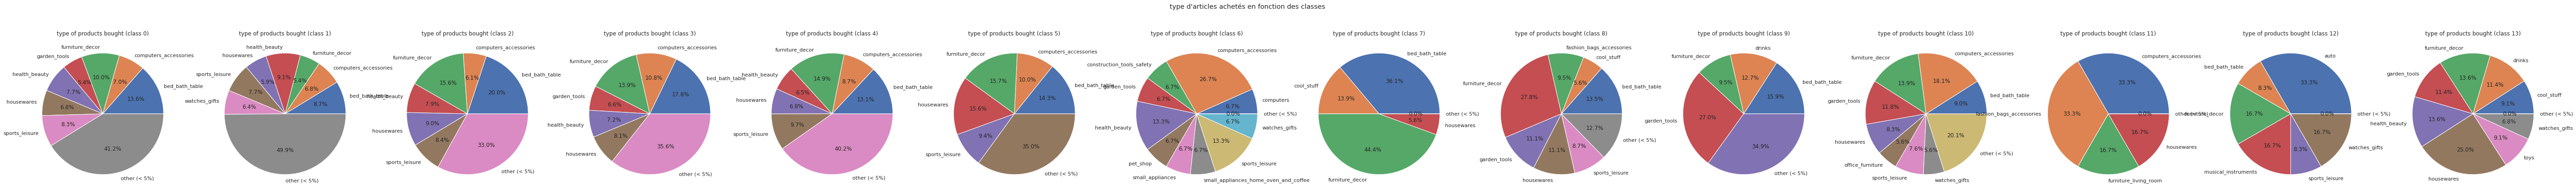

In [ ]:
type_panier(X_without_outliers_unscaled,data_merge_full,y_dbscan_without_outliers)

**Remarque:** Avec l'approche de segmentation par DBSCAN en variant les hyperparamètres et en gardant le meilleur modèle (En considérant l'indice de silhouette), on constate qu'une classe regroupe la quasi-totalité des clients. L'approche de segmentation par **DBSCAN semble donc inappropriée** à ce type de données en complexité et en résultat obtenu (Cela peut s'expliquer par l'absence de groupe de densité différentes/ une densité globale homogène).\
**ATTENTION:** Les centroïdes ne decrivent pas bien les données de leurs classes à cause du DBSCAN qui forme des classes par densité.

## Feature engineering 7 variables

Pour cette approche, on garde: **les variables RFM, le poid, le volume, la categorie du produit (converti en proportion), et la note de satisfaction client.**

### Pre-selection des variables

In [ ]:
data_Kmeans = data_merge_full.copy()

In [ ]:
col_keep = ["customer_unique_id","product_weight_g",
            "product_length_cm","product_height_cm","product_width_cm",
            "freight_value","product_category_name","review_score"]
data_Kmeans = data_Kmeans[col_keep]
data_Kmeans.head(5)

customer_unique_id  ...  review_score
0  68a5590b9926689be4e10f4ae2db21a8  ...             4
1  68a5590b9926689be4e10f4ae2db21a8  ...             4
2  64190b91b656ab8f37eb89b93dc84584  ...             5
3  1d47144362c14e94ccdd213e8ec277d5  ...             5
4  c8cf6cb6b838dc7a33ed199b825e8616  ...             5

[5 rows x 8 columns]

### Ajout de variables

On ajoute la variable **"product_volume" = le volume du 1er produit acheté par le client**

In [ ]:
data_Kmeans["product_volume"] = data_Kmeans["product_length_cm"]*data_Kmeans["product_height_cm"]*data_Kmeans["product_width_cm"]
data_Kmeans.drop(["product_length_cm","product_height_cm","product_width_cm"], axis=1, inplace=True)


On ajoute la variable **"PCN_proportion" = la proportion que représente le type d'article acheté par le client**

In [ ]:
PCN_proportion = data_merge_full["product_category_name"].value_counts()/data_merge_full.shape[0]
dict_PCN_proportion = PCN_proportion.to_dict()

In [ ]:
data_Kmeans.replace({"product_category_name": dict_PCN_proportion}, inplace=True)
data_Kmeans.rename(columns={'product_category_name': 'PCN_proportion'}, inplace=True)
data_Kmeans.head(5)

customer_unique_id  ...  product_volume
0  68a5590b9926689be4e10f4ae2db21a8  ...         31500.0
1  68a5590b9926689be4e10f4ae2db21a8  ...         31500.0
2  64190b91b656ab8f37eb89b93dc84584  ...          3724.0
3  1d47144362c14e94ccdd213e8ec277d5  ...          8000.0
4  c8cf6cb6b838dc7a33ed199b825e8616  ...          8000.0

[5 rows x 6 columns]

On ré-utilise les **Variables RFM**

In [ ]:
rfm_df_ids = rfm_df.copy()
rfm_df_ids["customer_unique_id"] = data_merge["customer_unique_id"].copy()
rfm_df_ids.head(5)

freq  prices_tot  recency                customer_unique_id
0     2      370.00     -234  68a5590b9926689be4e10f4ae2db21a8
2     1       79.79     -186  64190b91b656ab8f37eb89b93dc84584
3     1      149.00     -211  1d47144362c14e94ccdd213e8ec277d5
4     1      179.99     -511  c8cf6cb6b838dc7a33ed199b825e8616
5     1     1199.00     -204  d16000272660a1fef81482ad75ba572a

In [ ]:
data_Kmeans = pd.merge(data_Kmeans, rfm_df_ids, on='customer_unique_id')
data_Kmeans.head(5)

customer_unique_id  product_weight_g  ...  prices_tot  recency
0  68a5590b9926689be4e10f4ae2db21a8            1300.0  ...      370.00     -234
1  68a5590b9926689be4e10f4ae2db21a8            1300.0  ...      370.00     -234
2  64190b91b656ab8f37eb89b93dc84584             245.0  ...       79.79     -186
3  1d47144362c14e94ccdd213e8ec277d5            6550.0  ...      149.00     -211
4  c8cf6cb6b838dc7a33ed199b825e8616            7650.0  ...      179.99     -511

[5 rows x 9 columns]

### Drop doublons

In [ ]:
print("From "+ str(data_Kmeans.shape[0]) + " rows")
data_Kmeans.drop_duplicates(subset ="customer_unique_id", inplace = True)
print("To "+ str(data_Kmeans.shape[0]) +" rows (after drop duplicate)")

From 111156 rows
To 93671 rows (after drop duplicate)


### Scale

In [ ]:
sc2 = StandardScaler()

data_to_scale = data_Kmeans.drop(['customer_unique_id'], axis=1, inplace=False)
# 2 Nan values, need fillna()
#data_to_scale.dropna(inplace=True)
data_to_scale.fillna(method="ffill",inplace=True)
df_scale_Kmeans = sc2.fit_transform(data_to_scale)
df_scale_Kmeans = pd.DataFrame(df_scale_Kmeans, columns=data_to_scale.columns)
df_scale_Kmeans.head(5)

product_weight_g  freight_value  ...  prices_tot   recency
0         -0.215428      -0.414217  ...    1.046379  0.050807
1         -0.495112      -0.747226  ...   -0.289987  0.364486
2          1.176362       1.553220  ...    0.028713  0.201111
3          1.467975       1.411395  ...    0.171416 -1.759385
4          2.051202       7.121900  ...    4.863777  0.246856

[5 rows x 8 columns]

In [ ]:
"""plot_NaN(data_Kmeans, limite = 0)"""

'plot_NaN(data_Kmeans, limite = 0)'

In [ ]:
"""print("Nombre d'individus avant supression des lignes: "+str(df_scale_Kmeans.shape[0]))
df_scale_Kmeans.dropna(inplace=True)
print("Nombre d'individus apres supression des lignes: "+str(df_scale_Kmeans.shape[0]))"""

'print("Nombre d\'individus avant supression des lignes: "+str(df_scale_Kmeans.shape[0]))\ndf_scale_Kmeans.dropna(inplace=True)\nprint("Nombre d\'individus apres supression des lignes: "+str(df_scale_Kmeans.shape[0]))'

## Segmentation 7 variables

On test le K-means avec les **nouvelles variables**.

### Segmentation Kmeans

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

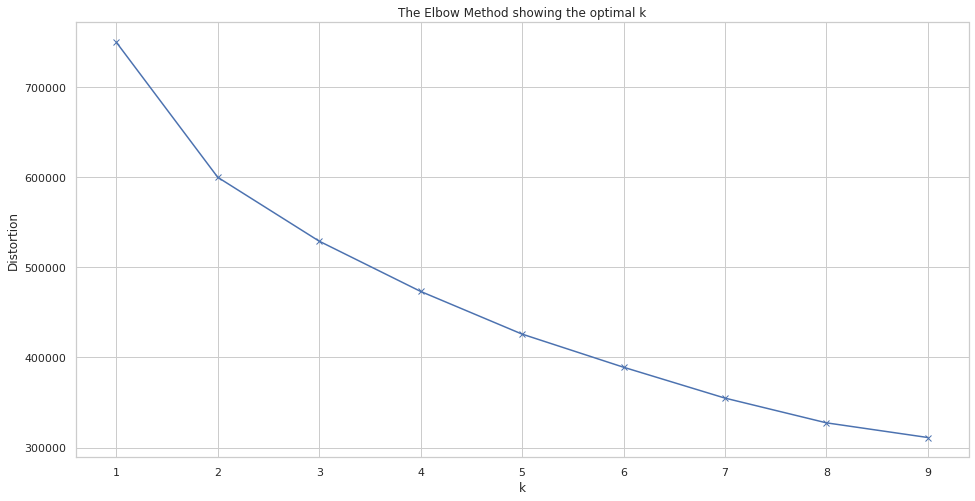

In [ ]:
elbowMethod(df_scale_Kmeans)

#### Description des classes

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


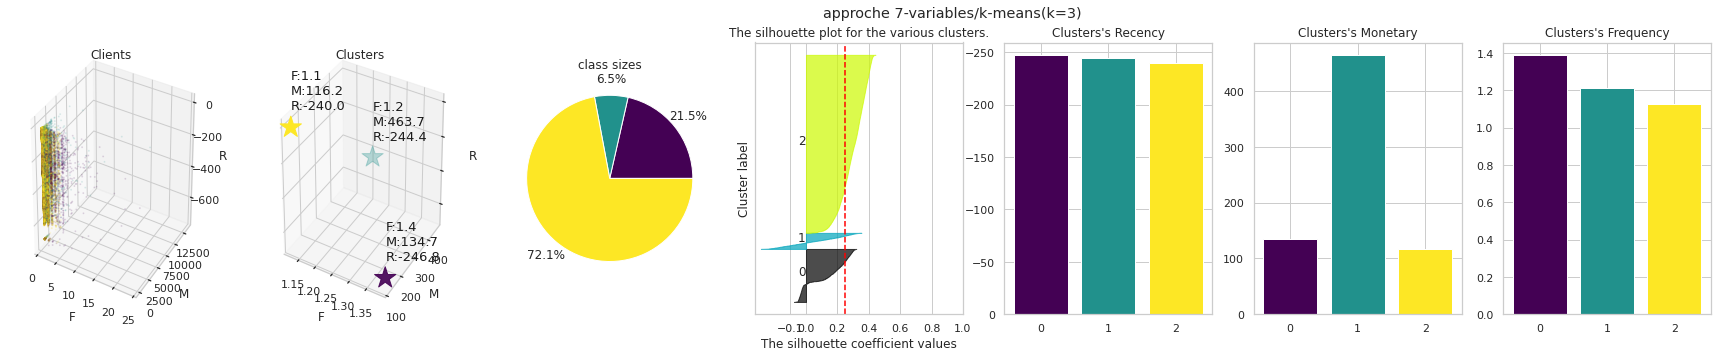

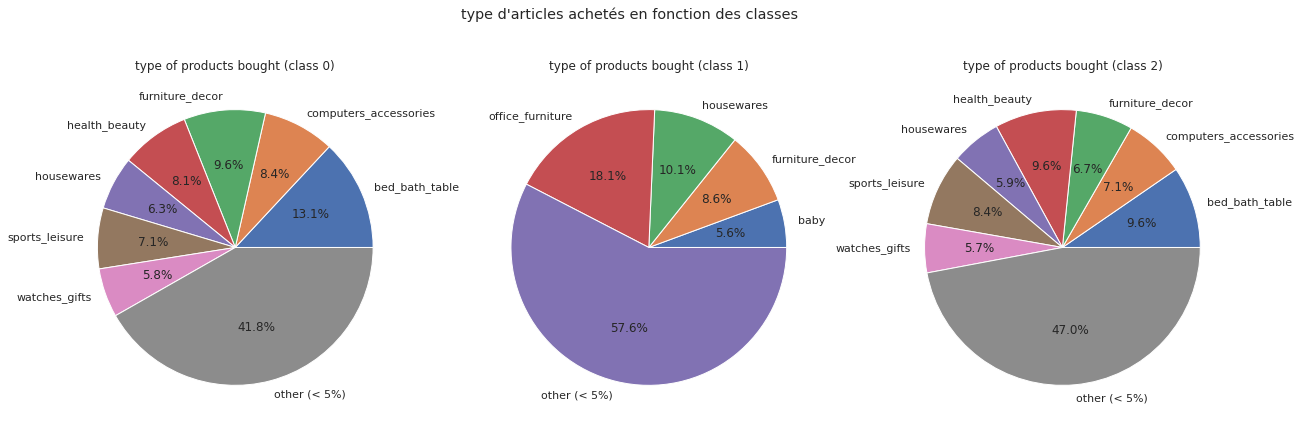

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


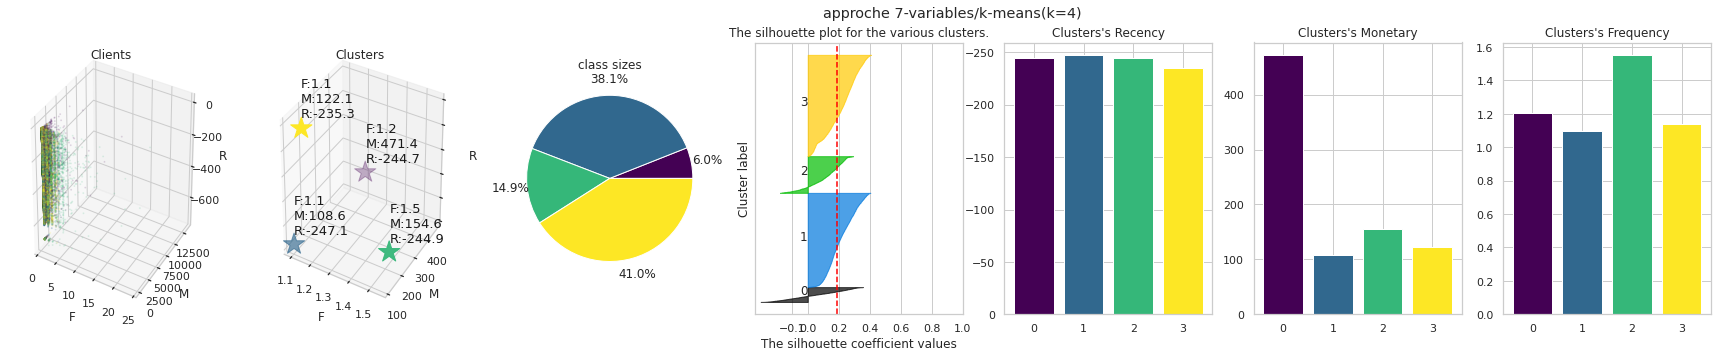

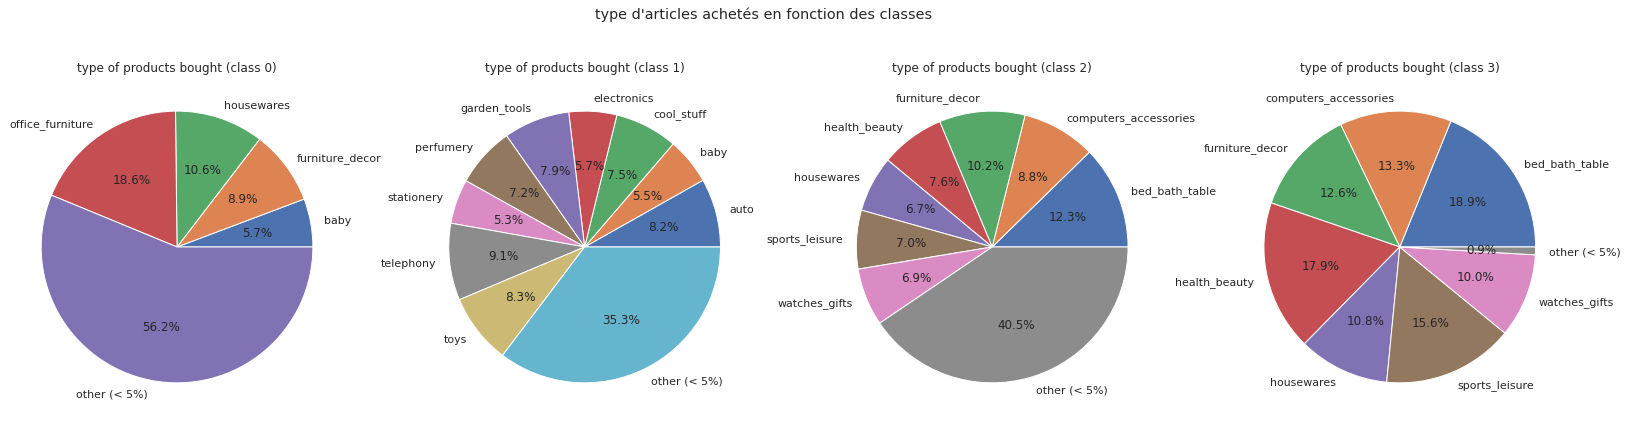

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


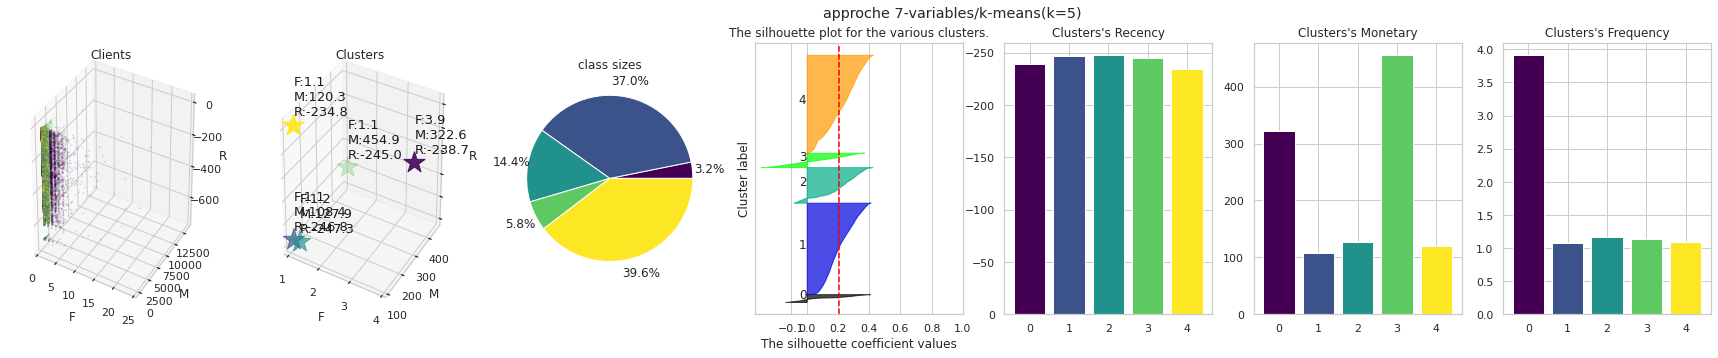

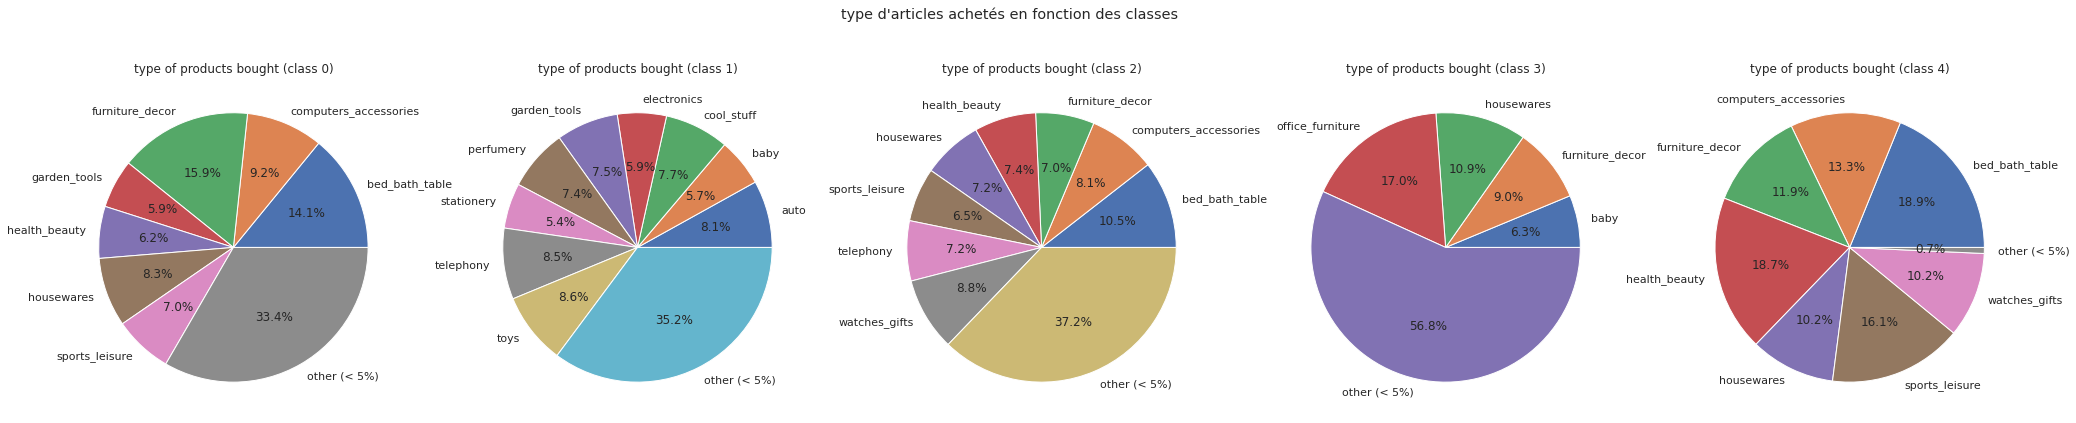

k=3       k=4       k=5
Silhouette  0.245751  0.189843  0.204081
Davis B.    1.629374  1.575798  1.398287

In [ ]:
plt_RFM_Kmeans2 = []
S_score = []
DB_score = []
y_kmeans_list2 = []

for nbCluster in range(3,6):
  kmeanModel = KMeans(n_clusters=nbCluster)
  kmeanModel.fit(df_scale_Kmeans)
  y_kmeans = kmeanModel.predict(df_scale_Kmeans)
  y_kmeans_list2.append(y_kmeans)
  centroides = kmeanModel.cluster_centers_
  centroides_unscaled = sc2.inverse_transform(centroides).T
  S_score_k = silhouette_score(df_scale_Kmeans, y_kmeans)
  S_score.append(S_score_k)
  DB_score.append(davies_bouldin_score(df_scale_Kmeans, y_kmeans))
  plt_RFM_Kmeans.append(plotCluster("approche 7-variables/k-means(k="+str(nbCluster)+")",
                                    data_to_scale,y_kmeans,centroides_unscaled,df_scale_Kmeans,S_score_k))
  type_panier(data_merge,data_merge_full,y_kmeans)

score_RFM2_Kmeans = [S_score,DB_score]
pd.DataFrame(score_RFM2_Kmeans, columns=["k=3","k=4","k=5"],index=["Silhouette","Davis B."])

**Remarque:** Contrairement à l'approche avec uniquement les variables RFM, on constate ici qu'en faisant varier l'hyperparamètre "k", on obtient des segmentations plutôt différentes:\
**k=3:** 2 classes majoritaires se distinguant par l'argent dépensé\
**k=4:** 2 classes majoritaires quasi similaires\
**k=5:** 3 classes majoritaires quasi similaires sauf pour une qui se distingue par une récence plus ancienne des clients.

### Segmentation DBSCAN

Choisir la taille des données à conserver pour le DBSCAN (complexité élevé) ? garder la meme taille

In [ ]:
# choose len of data for dbscan (30 000 on google colab free is the threshold)
#lenData = 30000
X = df_scale_Kmeans[:lenData]

In [ ]:
y_dbscan2,S_score = DBSCAN_GridSearch(X, eps=[1,1.5])

param: eps=1 min_samples=1
score: -0.18540553093976445
Number of clusters: 1794
param: eps=1 min_samples=2
score: -0.1101286334474515
Number of clusters: 234
param: eps=1 min_samples=3
score: -0.004921726914466119
Number of clusters: 99
param: eps=1.5 min_samples=1
score: 0.030201842406421833
Number of clusters: 725
param: eps=1.5 min_samples=2
score: 0.07699486610259587
Number of clusters: 100
param: eps=1.5 min_samples=3
score: 0.09479769246479848
Number of clusters: 31
best param: eps=1.5 min_samples=3 (31 clusters)


In [ ]:
DB_score = davies_bouldin_score(X, y_dbscan2)
DB_score

1.7445688532140975

In [ ]:
score_RFM2_DBSCAN = [S_score,DB_score]

In [ ]:
centroids = []
for c in np.unique(y_dbscan2):
  centroid = X[y_dbscan2 == c].mean()
  centroids.append(centroid)
centroides_unscaled = sc2.inverse_transform(centroids).T

In [ ]:
Clusters_inertia2 = clusters_inertia(X,y_dbscan2,[c.values for c in centroids])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


In [ ]:
data_lenData = data_rfm[:lenData]
outliers2 = data_lenData[y_dbscan2 == -1]

data_lenData.reset_index(inplace=True, drop=True)
outliers = data_lenData[y_dbscan2 == -1]

In [ ]:
X_without_outliers = X.drop(outliers.index, inplace=False)
y_dbscan2_without_outliers = y_dbscan2[y_dbscan2 != -1]
data_rfm_without_outliers = data_rfm.drop(outliers2.index, inplace=False)

In [ ]:
X_without_outliers_unscaled = data_merge.iloc[X_without_outliers.index]

#### Description des classes

1/7..
2/7..
3/7..
4/7..
5/7..
6/7..
7/7..


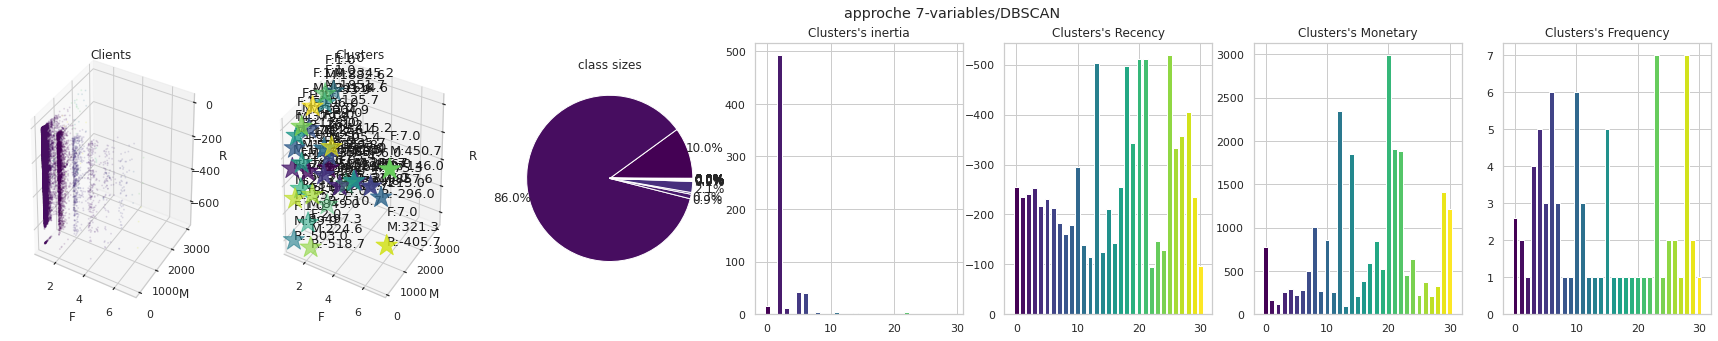

DBSCAN
Silhouette  0.094798
Davis B.    1.744569

In [ ]:
plt_RFM_DBSCAN = plotCluster("approche 7-variables/DBSCAN",X_without_outliers_unscaled,
                             y_dbscan2_without_outliers,
                             centroides_unscaled,
                             X_without_outliers,
                             S_score,vis_silhouette=False,inertiaS=Clusters_inertia2)
pd.DataFrame(score_RFM2_DBSCAN, columns=["DBSCAN"],index=["Silhouette","Davis B."])

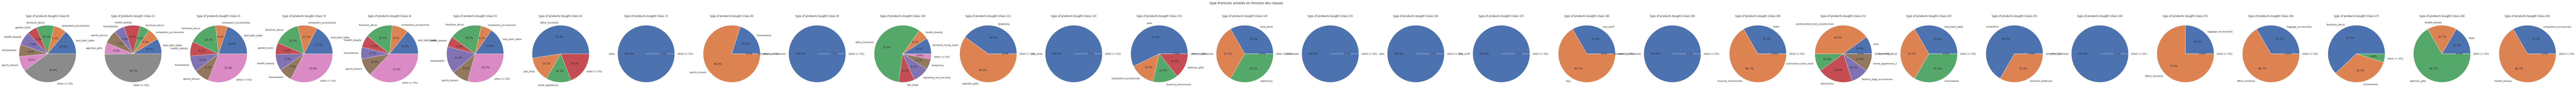

In [ ]:
type_panier(X_without_outliers_unscaled,data_merge_full,y_dbscan2_without_outliers)

**Remarque:** Comme pour l'approche DBSCAN avec uniquement les variables RFM, on constate ici que le modèle obtenu regroupe la quasi-totalité des clients dans 1 seule classe. Là aussi le **DBSCAN semble inapproprié** à nos données.\
**ATTENTION:** Les centroïdes ne decrivent pas bien les données de leurs classes à cause du DBSCAN qui forme des classes par densité.

## Comparaison des approches

### Choix du modele

In [ ]:
liste_approches = ["RFM","3-Var/Km3","3-Var/Km4","3-Var/Km5","3-Var/DBSCAN","7-Var/Km3","7-Var/Km4","7-Var/Km5","7-Var/DBSCAN"]

On choisi le modele final en fonction de ces indices:\
**silhouette** = est-ce que les points sont dans le bon cluster?\
**davies_bouldin_score** = est-ce que les clusters sont homogènes et distants entre eux?\
Idéalement, on a un modéle avec les metriques suivantes:\
**silhouette** = 1\
**davies_bouldin_score** = 0

In [ ]:
goal = [1,0]
RFM_k3,RFM_k4,RFM_k5 = tuple(np.array(score_RFM_Kmeans).T)
RFM2_k3,RFM2_k4,RFM2_k5 = tuple(np.array(score_RFM2_Kmeans).T)

scores = pd.DataFrame([score_RFM_quartile,
                       RFM_k3,
                       RFM_k4,
                       RFM_k5,
                       RFM2_k3,
                       RFM2_k4,
                       RFM2_k5,
                       score_RFM_DBSCAN,
                       score_RFM2_DBSCAN,
                       goal],
                      columns = ["silhouette","Davis Bouldin"],
                      index = liste_approches+["goal"])
scores

silhouette  Davis Bouldin
RFM             0.088155       2.856052
3-Var/Km3       0.417717       1.083793
3-Var/Km4       0.436765       0.834533
3-Var/Km5       0.462664       0.802044
3-Var/DBSCAN    0.245751       1.629374
7-Var/Km3       0.189843       1.575798
7-Var/Km4       0.204081       1.398287
7-Var/Km5       0.359163       1.692351
7-Var/DBSCAN    0.094798       1.744569
goal            1.000000       0.000000

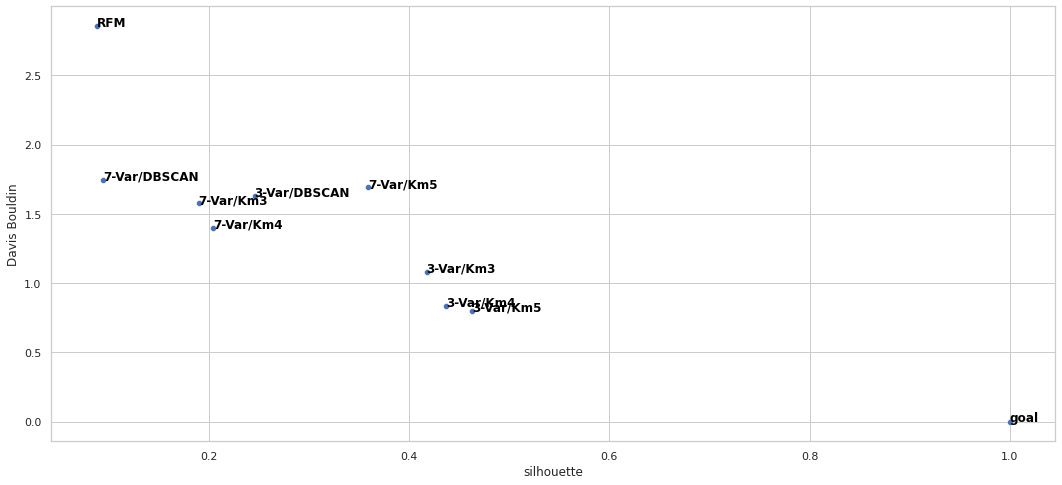

In [ ]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=scores, x="silhouette", y="Davis Bouldin")
for line in range(0,scores.shape[0]):
     plt.text(scores.silhouette[line], scores["Davis Bouldin"][line],
              scores.index[line], horizontalalignment='left', size='medium',
              color='black', weight='semibold')

plt.show()

**Remarque:** Le modèle qui combine les meilleures métriques est celui de l'approche "**3 variables, K-means, k=5**".

**Pour rappel:**

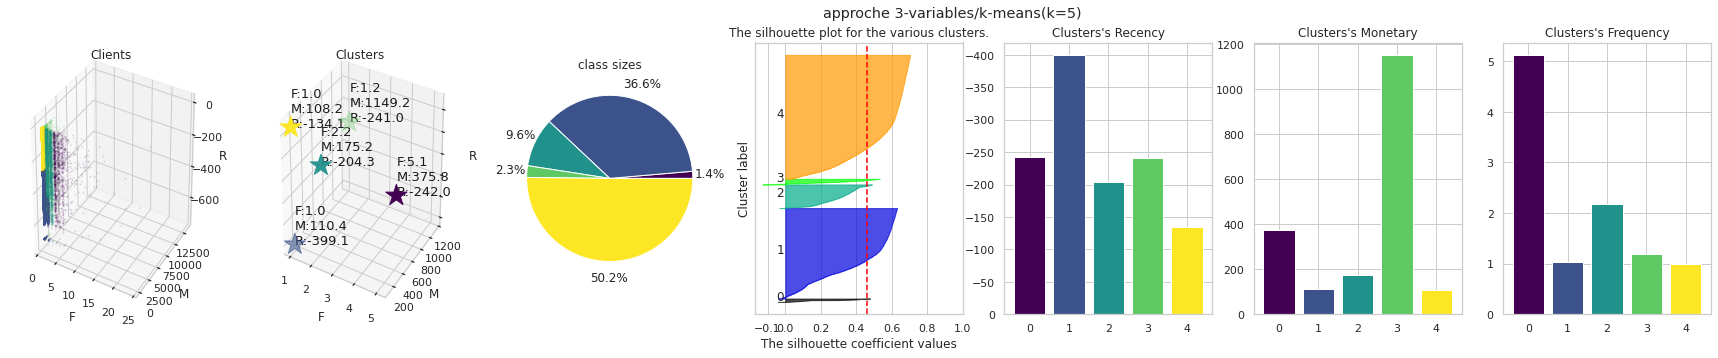

In [ ]:
plt_RFM_Kmeans[2]

**Remarque:** 2 classes sont interessantes d'un points de vue marketing, la 3 (avec une forte depense) et la 4 (avec une forte frequence). On labelise les clients en fonction de leurs classes.

On auras donc les classes: \
**"bronze"** = ancien client, faible depense, faible frequence (classe 2)\
**"silver"** = client recent, faible depense, faible frequence (classe 0)\
**"gold"** = client recent, faible depense, forte frequence (classe 1)\
**"premium_M"** = premium avec très forte depense (classe 3)\
**"premium_F"** = premium avec très forte frequence (classe 4)

In [ ]:
list_y_labels = ["silver","gold","bronze","premium_M","premium_F"]

In [ ]:
y_FINAL = y_kmeans_list[2]
y_labels_FINAL = [list_y_labels[y] for y in y_FINAL]
X_FINAL = data_rfm
X_FINAL_scale = data_RFM_scale

In [ ]:
centroides_FINAL = []
for y in np.unique(y_FINAL):
  centroid = X_FINAL[y_FINAL == y].mean()
  centroides_FINAL.append(centroid)

**+ d'infos**

In [ ]:
data_Kmeans["y"] = y_FINAL

In [ ]:
X_FINAL_full_data = pd.merge(data_Kmeans, data_merge_full, on='customer_unique_id')

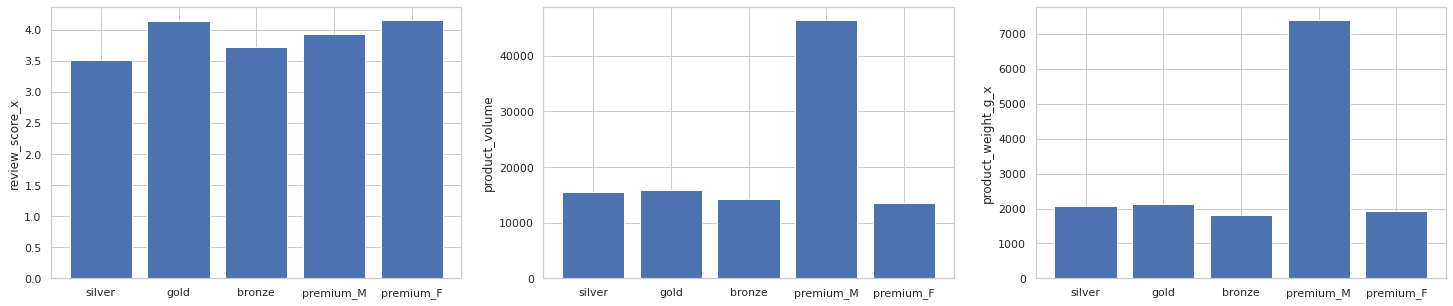

In [ ]:
cols = ["review_score_x","product_volume","product_weight_g_x"]
fig = plt.figure(figsize=(25, 5))
i = 0
for col in cols:
  i += 1
  ax = fig.add_subplot(1, 3, i)
  temp = X_FINAL_full_data[col]
  means_col = []
  for c in np.unique(y_FINAL):
    means_col.append(temp[X_FINAL_full_data["y"] == c].mean())
  data_plot = {'Class': list_y_labels, col: means_col}
  df_plot = pd.DataFrame(data=data_plot)
  ax.bar(df_plot["Class"], df_plot[col])
  ax.set_ylabel(col)

**Remarque:** Les clients labelisés "premium_F" on tendance à commander des articles lourds et volumineux.

### similitudes des approches

Pour 

In [ ]:
y_approches = [classes_RFM]
for y in y_kmeans_list:
  y_approches.append(y)
for y in y_kmeans_list2:
  y_approches.append(y)
y_approches.append(y_dbscan)
y_approches.append(y_dbscan2)
# y_approches contain all Y values from differents try

In [ ]:
rand_score_plot = []
i = 0
for y in y_approches:
  rand_score_plot.append([])
  for y2 in y_approches:
    rand_score_plot[i].append(adjusted_rand_score(y[:lenData],y2[:lenData]))
  i += 1

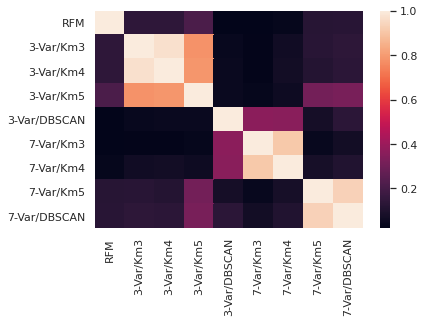

In [ ]:
sns.heatmap(pd.DataFrame(rand_score_plot,columns=liste_approches,index=liste_approches))

## Stabilité

Vérifions la **stabilité** du modèle choisi. On regarde la variation des metriques sur 10 essais en re-échantillonnant les données sur 80% de clients selectionnés hasard (Bootstrap Sampling)

In [ ]:
res = []
for i in range(10):
  idx_random = np.random.choice(range(X_FINAL_scale.shape[0]), size=int(X_FINAL_scale.shape[0]*8/10))
  X_random = X_FINAL_scale.iloc[idx_random]
  print(str(i)+"/10")
  kmeans = KMeans(n_clusters=5)
  kmeans.fit(X_random)
  y_kmeans = kmeans.predict(X_random)
  
  S_score = round(silhouette_score(X_random, y_kmeans),3)
  DB_score = round(davies_bouldin_score(X_random, y_kmeans),3)
  Kmeans5_score = [S_score,DB_score]
  res.append(Kmeans5_score)

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


In [ ]:
res_df = pd.DataFrame(res)

In [ ]:
std_sil = round(np.std(res_df.iloc[:,0]),3)
std_DB = round(np.std(res_df.iloc[:,0]),3)

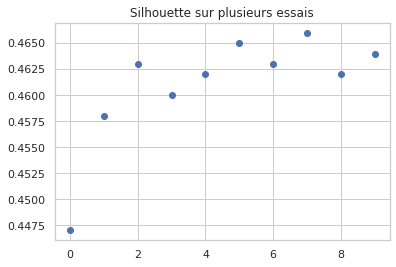

ecart-type Silhouette = 0.005


In [ ]:
plt.scatter(range(res_df.shape[0]),res_df.iloc[:,0], )
plt.title("Silhouette sur plusieurs essais")
ax.set_ylabel("Silhouette")
plt.show()
print("ecart-type Silhouette = "+str(std_sil))

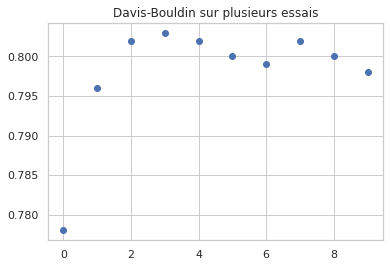

ecart-type Davis-Bouldin = 0.005


In [ ]:
plt.scatter(range(res_df.shape[0]),res_df.iloc[:,1])
plt.title("Davis-Bouldin sur plusieurs essais")
plt.show()
print("ecart-type Davis-Bouldin = "+str(std_DB))

**Remarque:** Les metriques sont **stables** sur plusieur essais de l'approche  "**RFM, K-means, k=5**".

## stratégie d’ajout de client

### Observation nouveaux clients

In [ ]:
orders_df.head(2)

order_id  ... order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  ...           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  ...           2018-08-13 00:00:00

[2 rows x 8 columns]

In [ ]:
print("From "+ str(orders_df.shape[0]) + " rows")
orders_df.drop_duplicates(subset ="customer_id", inplace = True)
print("To "+ str(orders_df.shape[0]) +" rows (after drop duplicate)")

From 99441 rows
To 99441 rows (after drop duplicate)


In [ ]:
orders_df["date"] = orders_df["order_purchase_timestamp"].apply(lambda x: datetime.fromisoformat(x))

In [ ]:
mask = (orders_df['date'] > '2017-01-01 00:00:00') & (orders_df['date'] <= '2018-01-01 00:00:00')
date_order_2017_2018 = orders_df['date'][mask]
date_plot = date_order_2017_2018.groupby(date_order_2017_2018.dt.month).count()
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
date_plot_df = pd.DataFrame({"New clients": date_plot,"Months":months})

Text(0.5, 1.0, 'Nombre de nouveaux clients par mois (2017-2018)')

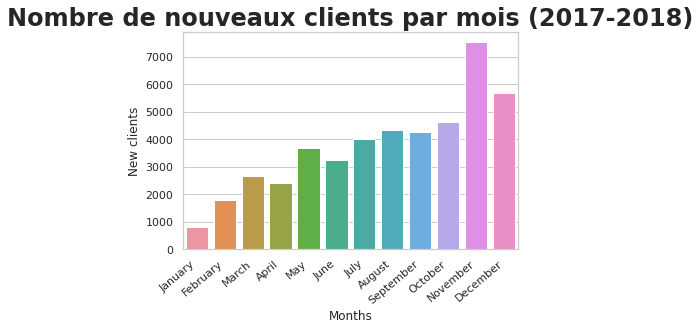

In [ ]:
ax = sns.barplot(x="Months", y="New clients", data=date_plot_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Nombre de nouveaux clients par mois (2017-2018)', fontdict= { 'fontsize': 24, 'fontweight':'bold'})

**Remarque:** On constate qu'il y'a plus de nouveaux clients en fin d'année.

In [ ]:
from random import randrange

index_random = randrange(X_FINAL.shape[0])
new_client = X_FINAL.iloc[index_random]
new_client

freq            4.0
prices_tot     56.0
recency      -475.0
Name: 50741, dtype: float64

### stratégie 1
Affecter les nouveaux clients aux cluster les plus proches

In [ ]:
dist_min = euclidean_distances([new_client],[centroides_FINAL[0]])
idx_c_min = 0
c_idx = 0
for c in centroides_FINAL:
  distance = euclidean_distances([new_client],[c])
  print("distance from "+list_y_labels[c_idx]+" = "+str(distance[0][0]))
  if distance < dist_min:
    dist_min = distance
    idx_c_min = c_idx
  c_idx += 1
print("new client's label should be: \""+list_y_labels[idx_c_min]+"\"")

distance from silver = 395.6671578312445
distance from gold = 93.40449016061135
distance from bronze = 295.7523455156659
distance from premium_M = 1118.4165593919097
distance from premium_F = 344.8638350683732
new client's label should be: "gold"


### stratégie 2
Appliquer un algorithme de classification supervisé aux nouveaux clients (par exemple Knn)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_FINAL, y_FINAL)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
idx_c = neigh.predict([new_client])
print("new client's label should be: \""+list_y_labels[idx_c[0]]+"\"")

new client's label should be: "gold"


### stratégie 3
Re appliquer la segmentation à partir d'un certain nombre de nouveau clients (par exemple à partir de 20% de nouveaux client = 60 000)

## Conclusion

Avec le modèle choisi, **certaines catégories de produits sont plus fréquentes dans certaines classes** (watches_gift à 15% dans la classe "premium_M"), et d'autres catégories sont omniprésentes (computer 5-10% sur toutes les classes).

De plus, bien que le modèle retenu a les meilleurs scores, il y a plusieurs choix de modèles possibles en fonction des besoins marketing (nottament l'approche Kmeans sur 3 variables avec k = 4 qui a aussi de bonnes performances).